## Dependencias

In [1]:
%%capture
!pip install giotto-tda

In [2]:
%%capture
!pip install gudhi

In [3]:
import pandas as pd
import numpy as np
import numpy as np
import gudhi as gd  
from sklearn import manifold
from pylab import *
from sklearn.decomposition import PCA
from gtda.plotting import plot_point_cloud
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from keras.models import Sequential
from statistics import mode
from scipy.stats import mode 
from math import floor,ceil
%matplotlib inline
# import sklearn_tda


### Importar datos y preprocesamiento

In [4]:
object=pd.read_pickle('uke_eggedal_data_challenge.pkl')
df=pd.DataFrame.from_dict(object,orient='index')

In [5]:
df=df.T
df

,flow,obs_tas,flow_dates,obs_lon_lat,obs_pr,obs_dates
0,1.723781,"[-10.600000381469727, -9.699999809265137, -6.6...",1958-01-04,9.37,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000...",1957-01-01
1,0.960882,"[-20.5, -19.100000381469727, -12.0, -17.700000...",1958-01-05,60.23,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20000000...",1957-01-02
2,0.001,"[-23.600000381469727, -22.5, -15.1000003814697...",1958-01-06,None,"[0.10000000149011612, 0.0, 0.30000001192092896...",1957-01-03
3,0.001,"[-16.200000762939453, -16.0, -14.1000003814697...",1958-01-07,None,"[1.0, 0.0, 1.0, 1.100000023841858, 0.899999976...",1957-01-04
4,0.316796,"[-7.900000095367432, -7.800000190734863, -9.5,...",1958-01-08,None,"[9.300000190734863, 8.600000381469727, 8.0, 8....",1957-01-05
...,...,...,...,...,...,...
21541,1.812796,"[-12.5, -11.699999809265137, -8.60000038146972...",2016-12-26,None,"[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27
21542,None,"[-12.5, -11.899999618530273, -9.10000038146972...",NaT,None,"[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28
21543,None,"[-11.899999618530273, -11.399999618530273, -8....",NaT,None,"[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29
21544,None,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...",NaT,None,"[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30


In [6]:
df_target=df[['flow_dates','flow']]
df_target.sort_values(by='flow_dates')
df_target=df_target.dropna()
df_target

,flow_dates,flow
0,1958-01-04,1.723781
1,1958-01-05,0.960882
2,1958-01-06,0.001
3,1958-01-07,0.001
4,1958-01-08,0.316796
...,...,...
21537,2016-12-22,4.84329
21538,2016-12-23,3.75697
21539,2016-12-24,3.556818
21540,2016-12-25,3.402133


In [7]:
df_predic=df[['obs_dates','obs_tas','obs_pr']]
df_predic.sort_values(by='obs_dates')
df_predic=df_predic.dropna()
df_predic

,obs_dates,obs_tas,obs_pr
0,1957-01-01,"[-10.600000381469727, -9.699999809265137, -6.6...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10000000..."
1,1957-01-02,"[-20.5, -19.100000381469727, -12.0, -17.700000...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.20000000..."
2,1957-01-03,"[-23.600000381469727, -22.5, -15.1000003814697...","[0.10000000149011612, 0.0, 0.30000001192092896..."
3,1957-01-04,"[-16.200000762939453, -16.0, -14.1000003814697...","[1.0, 0.0, 1.0, 1.100000023841858, 0.899999976..."
4,1957-01-05,"[-7.900000095367432, -7.800000190734863, -9.5,...","[9.300000190734863, 8.600000381469727, 8.0, 8...."
...,...,...,...
21541,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100..."
21542,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6...."
21543,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099..."
21544,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5...."


In [8]:
df_final=df_predic.merge(df_target,how='inner',left_on='obs_dates',right_on='flow_dates')
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796
...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,2.17704
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,4.87625
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,4.99884
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,4.428777


In [9]:
df_final['temperatures'] = df_final['obs_tas'].apply(lambda x: np.mean(x))
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow,temperatures
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781,-12.655556
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882,-7.722222
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001,-8.088889
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001,-10.122222
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796,-17.455555
...,...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,2.17704,-9.944444
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,4.87625,-10.288889
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,4.99884,-9.411111
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,4.428777,-5.055556


In [10]:
df_final['precipitations'] = df_final['obs_pr'].apply(lambda x: np.mean(x))
df_final

,obs_dates,obs_tas,obs_pr,flow_dates,flow,temperatures,precipitations
0,1958-01-04,"[-12.800000190734863, -13.0, -13.0, -12.5, -12...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",1958-01-04,1.723781,-12.655556,0.000000
1,1958-01-05,"[-7.800000190734863, -7.900000095367432, -8.39...","[2.0, 2.200000047683716, 3.0, 3.29999995231628...",1958-01-05,0.960882,-7.722222,2.588889
2,1958-01-06,"[-11.0, -9.899999618530273, -6.5, -8.5, -9.0, ...","[12.699999809265137, 11.0, 16.5, 12.5, 11.1999...",1958-01-06,0.001,-8.088889,12.766667
3,1958-01-07,"[-13.199999809265137, -12.199999809265137, -7....","[6.599999904632568, 6.900000095367432, 9.60000...",1958-01-07,0.001,-10.122222,6.877778
4,1958-01-08,"[-19.899999618530273, -19.299999237060547, -15...","[3.4000000953674316, 3.5999999046325684, 2.700...",1958-01-08,0.316796,-17.455555,3.411111
...,...,...,...,...,...,...,...
21173,2015-12-27,"[-12.5, -11.699999809265137, -8.60000038146972...","[2.200000047683716, 0.10000000149011612, 1.100...",2015-12-27,2.17704,-9.944444,0.555556
21174,2015-12-28,"[-12.5, -11.899999618530273, -9.10000038146972...","[5.5, 4.900000095367432, 8.300000190734863, 6....",2015-12-28,4.87625,-10.288889,4.888889
21175,2015-12-29,"[-11.899999618530273, -11.399999618530273, -8....","[1.7999999523162842, 1.7000000476837158, 2.099...",2015-12-29,4.99884,-9.411111,1.277778
21176,2015-12-30,"[-7.0, -6.5, -3.4000000953674316, -5.900000095...","[4.099999904632568, 3.5, 4.599999904632568, 5....",2015-12-30,4.428777,-5.055556,3.444444


### Se separan datos por años 
Soltamos una columna redundante e informacion que ya no es util 

In [11]:
df_final=df_final.drop(['obs_tas','obs_pr','flow_dates'],axis=1)
df_final

,obs_dates,flow,temperatures,precipitations
0,1958-01-04,1.723781,-12.655556,0.000000
1,1958-01-05,0.960882,-7.722222,2.588889
2,1958-01-06,0.001,-8.088889,12.766667
3,1958-01-07,0.001,-10.122222,6.877778
4,1958-01-08,0.316796,-17.455555,3.411111
...,...,...,...,...
21173,2015-12-27,2.17704,-9.944444,0.555556
21174,2015-12-28,4.87625,-10.288889,4.888889
21175,2015-12-29,4.99884,-9.411111,1.277778
21176,2015-12-30,4.428777,-5.055556,3.444444


In [12]:
df_final['obs_dates'].head()

0   1958-01-04
1   1958-01-05
2   1958-01-06
3   1958-01-07
4   1958-01-08
Name: obs_dates, dtype: datetime64[ns]

In [13]:
df_final['obs_dates'].tail()

21173   2015-12-27
21174   2015-12-28
21175   2015-12-29
21176   2015-12-30
21177   2015-12-31
Name: obs_dates, dtype: datetime64[ns]

Notese que iniciamos en 1954, y este no fue año bisiesto, pero 1960 si, y que tenemos una observacion diaria. Separemos los datos por año, hagamos sus encajes y veamos como se van moviendo los centros de masa de los encajes a traves del tiempo. 

In [14]:
'''def el_Quique_500(df: pd.DataFrame, start: int=1957,n: int=2) -> list:
  #Separa los datos por años, respetando los años bisiestos
  years=[]
  year= df['obs_dates'].iloc[0].year
  l,r=0,0
  while(r<len(df)-(1+n)):
    # Verificamos si la siguiente observacion sigue siendo parte del mismo año
    # Si no es el caso, populamos la lista y actualizamos los punteros
    if df['obs_dates'].iloc[r+1].year!=year+(1+n):
      years.append(df.iloc[l:r+1])
      l=r+1
      year+=1
    r+=1
  years.append(df.iloc[l:r+1])
  return years'''

"def el_Quique_500(df: pd.DataFrame, start: int=1957,n: int=2) -> list:\n  #Separa los datos por años, respetando los años bisiestos\n  years=[]\n  year= df['obs_dates'].iloc[0].year\n  l,r=0,0\n  while(r<len(df)-(1+n)):\n    # Verificamos si la siguiente observacion sigue siendo parte del mismo año\n    # Si no es el caso, populamos la lista y actualizamos los punteros\n    if df['obs_dates'].iloc[r+1].year!=year+(1+n):\n      years.append(df.iloc[l:r+1])\n      l=r+1\n      year+=1\n    r+=1\n  years.append(df.iloc[l:r+1])\n  return years"

In [15]:
def el_Quique_500(df: pd.DataFrame):
  years = []
  df["obs_dates"] = pd.to_datetime(df["obs_dates"])
  df=df.set_index("obs_dates")
  for i in df.resample('3Y'):
    a = pd.DataFrame(i[1])
    a.reset_index(inplace=True)
    years.append(a)
  return years

In [16]:
years=el_Quique_500(df_final)

In [17]:
len(years)

20

In [18]:
years

[     obs_dates      flow  temperatures  precipitations
 0   1958-01-04  1.723781    -12.655556        0.000000
 1   1958-01-05  0.960882     -7.722222        2.588889
 2   1958-01-06     0.001     -8.088889       12.766667
 3   1958-01-07     0.001    -10.122222        6.877778
 4   1958-01-08  0.316796    -17.455555        3.411111
 ..         ...       ...           ...             ...
 357 1958-12-27  0.836054     -6.000000        0.000000
 358 1958-12-28     0.001     -7.633333        0.211111
 359 1958-12-29   0.53879    -10.044444        9.677778
 360 1958-12-30  0.280476    -10.966667        0.011111
 361 1958-12-31  0.207946    -10.755555        0.455556
 
 [362 rows x 4 columns],
       obs_dates      flow  temperatures  precipitations
 0    1959-01-01  0.288463     -7.166667        1.033333
 1    1959-01-02  0.876782     -8.000000       10.155556
 2    1959-01-03     0.001     -5.777778       18.022222
 3    1959-01-04   0.11251     -5.477778        0.266667
 4    1959-01-05

## TDA por años con datos sin suavizar

Se usara el metodo de seleccion de parametros por moda 

In [19]:
max_embedding_dimension = 50
max_time_delay = 7
stride = 1

embedder_periodic = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)


In [20]:
def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
    """Fits a Takens embedder and displays optimal search parameters."""
    y_embedded = embedder.fit_transform(y)
    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(
            f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
        )
    return embedder.dimension,embedder.time_delay_,y_embedded

In [21]:
x,y,z=[],[],[]
for i in range(1,len(years)):
  x1,y1,_ = fit_embedder(embedder_periodic, years[i]['precipitations'],False)
  x2,y2,_ = fit_embedder(embedder_periodic, years[i]['temperatures'],False)
  x3,y3,_ = fit_embedder(embedder_periodic, years[i]['flow'].astype('float32'),False) 
  x.append((x1,y1))
  y.append((x2,y2))
  z.append((x3,y3))
x1=int(mode(x)[0][0][0])
y1=int(mode(x)[0][0][1])
x2=int(mode(y)[0][0][0])
y2=int(mode(y)[0][0][1])
x3=int(mode(z)[0][0][0])
y3=int(mode(z)[0][0][1])

In [22]:
embedder_Precs = SingleTakensEmbedding(
    parameters_type="fixed",
    time_delay=y1,
    dimension=x1,
    stride=stride,
)
embedder_Temps = SingleTakensEmbedding(
    parameters_type="fixed",
    time_delay=y2,
    dimension=x2,
    stride=stride,
)
embedder_Flows = SingleTakensEmbedding(
    parameters_type="fixed",
    time_delay=y3,
    dimension=x3,
    stride=stride,
)

In [23]:
embedder_Precs

SingleTakensEmbedding(dimension=50, parameters_type='fixed', time_delay=7)

In [24]:
embedder_Temps

SingleTakensEmbedding(dimension=50, parameters_type='fixed', time_delay=7)

In [25]:
embedder_Flows

SingleTakensEmbedding(dimension=50, parameters_type='fixed', time_delay=7)

### Funciones auxiliares

In [26]:
def tank(dfs: list) -> list:
  '''Usando los encajes definidos anteriormente, obtiene los primeros 2
  componentes principales de cada encaje de las variables'''
  pca2 = PCA(n_components=2)
  precs2d,temps2d,flows2d=[],[],[]
  for i in range(len(dfs)):
    _,_,precipitacion_embedded = fit_embedder(embedder_Precs, 
                                              dfs[i]['precipitations'],False)
    precs2d.append(pca2.fit_transform(precipitacion_embedded))
    _,_,temperatures_embedded = fit_embedder(embedder_Temps, 
                                             dfs[i]['temperatures'],False)
    temps2d.append(pca2.fit_transform(temperatures_embedded))
    _,_,flow_embedded = fit_embedder(embedder_Flows, dfs[i]['flow'],False)
    flows2d.append(pca2.fit_transform(flow_embedded))
  return precs2d,temps2d,flows2d


In [27]:
precs2d,temps2d,flows2d=tank(years)

In [28]:
def die2dPlotterZeug(x:list,title:str,verbose_anot: bool=False)-> None:
  '''Devuelve un plot por año de los componentes principales en 2d, escala los 
  limites al maximo por eje visto en un año. Ajusta el ratio de aspecto. Marca
  el inicio y fin de cada encaje. Opcionalmente puede anotar toda la serie'''
  xl,yl=0,0
  # Busca los valores maximos para usarlos como limites en las graficas
  for i in range(len(x)):
    if max(x[i][:,0])>xl:
      xl=max(x[i][:,0])
    if max(x[i][:,1])>yl:
      yl=max(x[i][:,1])
  # Genera las graficas iterativamente
  fig, axs = plt.subplots(ceil(len(x)/4), 4,figsize=(25, 75))
  for i in range(len(x)):
    axs[floor(i/4), i%4].scatter(x[i][:,0],x[i][:,1])
    axs[floor(i/4), i%4].set_title('Periodo '+str(i+1)+' de '+title)
    axs[floor(i/4), i%4].set_xlabel('Componente principal 1')
    axs[floor(i/4), i%4].set_ylabel('Componente principal 2')
    axs[floor(i/4), i%4].set_xlim((-xl,xl))
    axs[floor(i/4), i%4].set_ylim((-yl,yl))
    axs[floor(i/4), i%4].annotate('s', (x[i][0][0], x[i][0][1]))
    if verbose_anot:
      for j in range(1,len(x[i])-1):
        axs[floor(i/4), i%4].annotate(j+1, (x[i][j][0], x[i][j][1]))
    axs[floor(i/4), i%4].annotate('e', (x[i][-1][0], x[i][-1][1]))
    axs[floor(i/4), i%4].set_aspect('equal','box')
  # Elimina subplots vacios si es que existen
  if len(x)<ceil(len(x)/4)*4:
    for j in range(i+1,ceil(len(x)/4)*4):
      fig.delaxes(axs[floor(j/4)][j%4])
  plt.show()


# Data sintetica

In [29]:
def sintetico(data,encajador)->None:
  '''Recibe una señal generica, obtiene su encaje. Marca el inicio y final'''
  pca2 = PCA(n_components=2)
  _,_,flow_embedded = fit_embedder(encajador, data,False)
  sinteticaPCA=pca2.fit_transform(flow_embedded)
  fig, axs = plt.subplots(figsize=(8,8))
  axs.scatter(sinteticaPCA[:,0],sinteticaPCA[:,1])
  axs.set_title('Señal sintetica')
  axs.set_xlabel('Componente principal 1')
  axs.set_ylabel('Componente principal 2')
  axs.annotate('s', (sinteticaPCA[0][0], sinteticaPCA[0][1]))
  axs.annotate('e', (sinteticaPCA[-1][0], sinteticaPCA[-1][1]))
  #axs.set_aspect('equal')
  mx,my=max(sinteticaPCA[:,0]),max(sinteticaPCA[:,1])
  gm=0
  if mx>=my:
    gm=mx
  else:
    gm=my
  axs.set_xlim(-gm,gm)
  axs.set_ylim(-gm,gm)


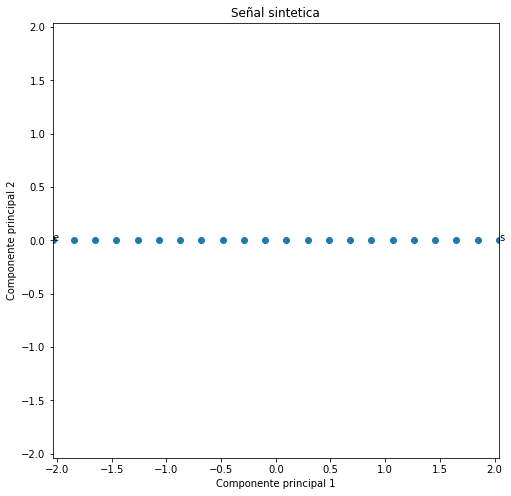

In [30]:
# Ejemplo 1: y=x
sintetico(np.linspace(0,10,365),embedder_Flows) 

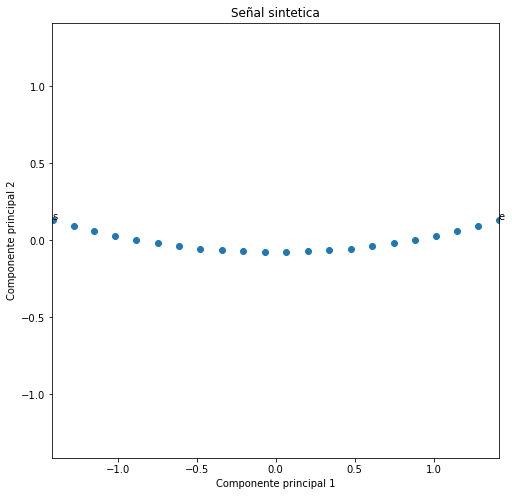

In [31]:
# Ejemplo 2, y=cos(x),x entre 0 y 10
sintetico(np.cos(np.linspace(0,10, num=365)),embedder_Flows)

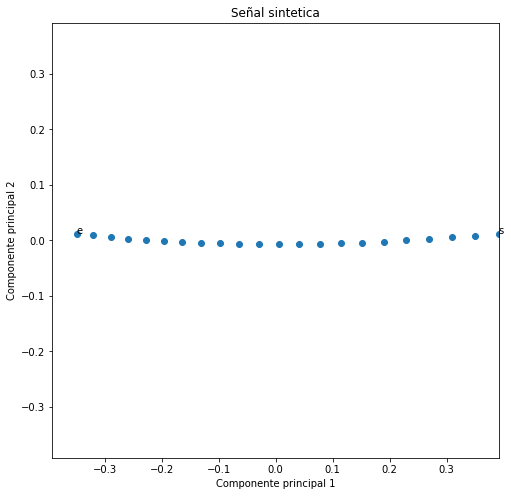

In [32]:
# Ejemplo 3, encaje de y=cos(x)/x para x entre 1 y 2pi
n=365
sintetico(np.cos(np.linspace(1, 2*np.pi, num=n))/np.linspace(1, 2*np.pi, num=n),embedder_Flows)

### Encajes bidimensionales

#### Precipitaciones

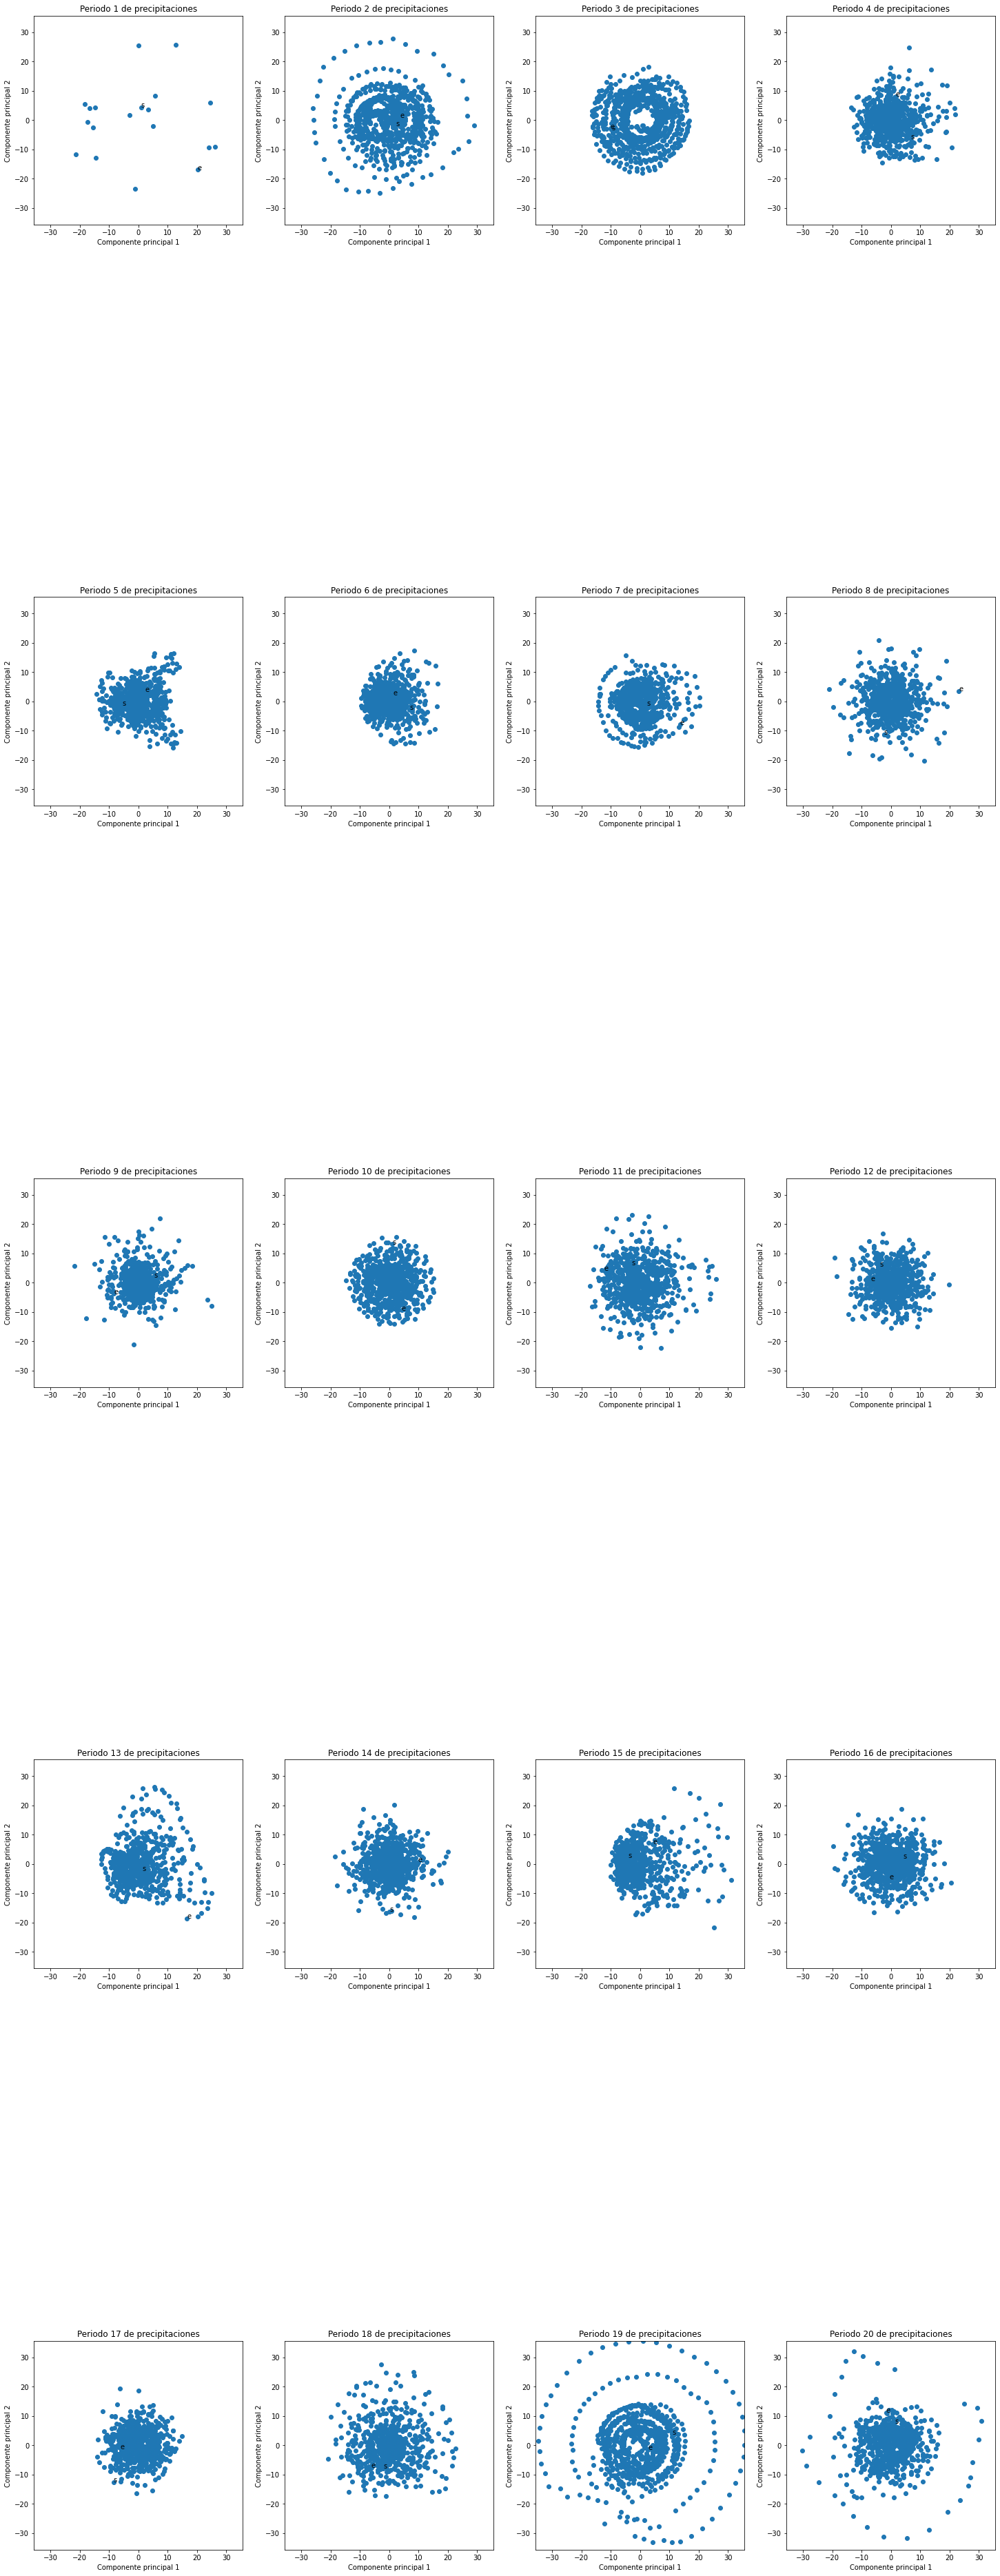

In [33]:
die2dPlotterZeug(precs2d,'precipitaciones')

#### Temperaturas

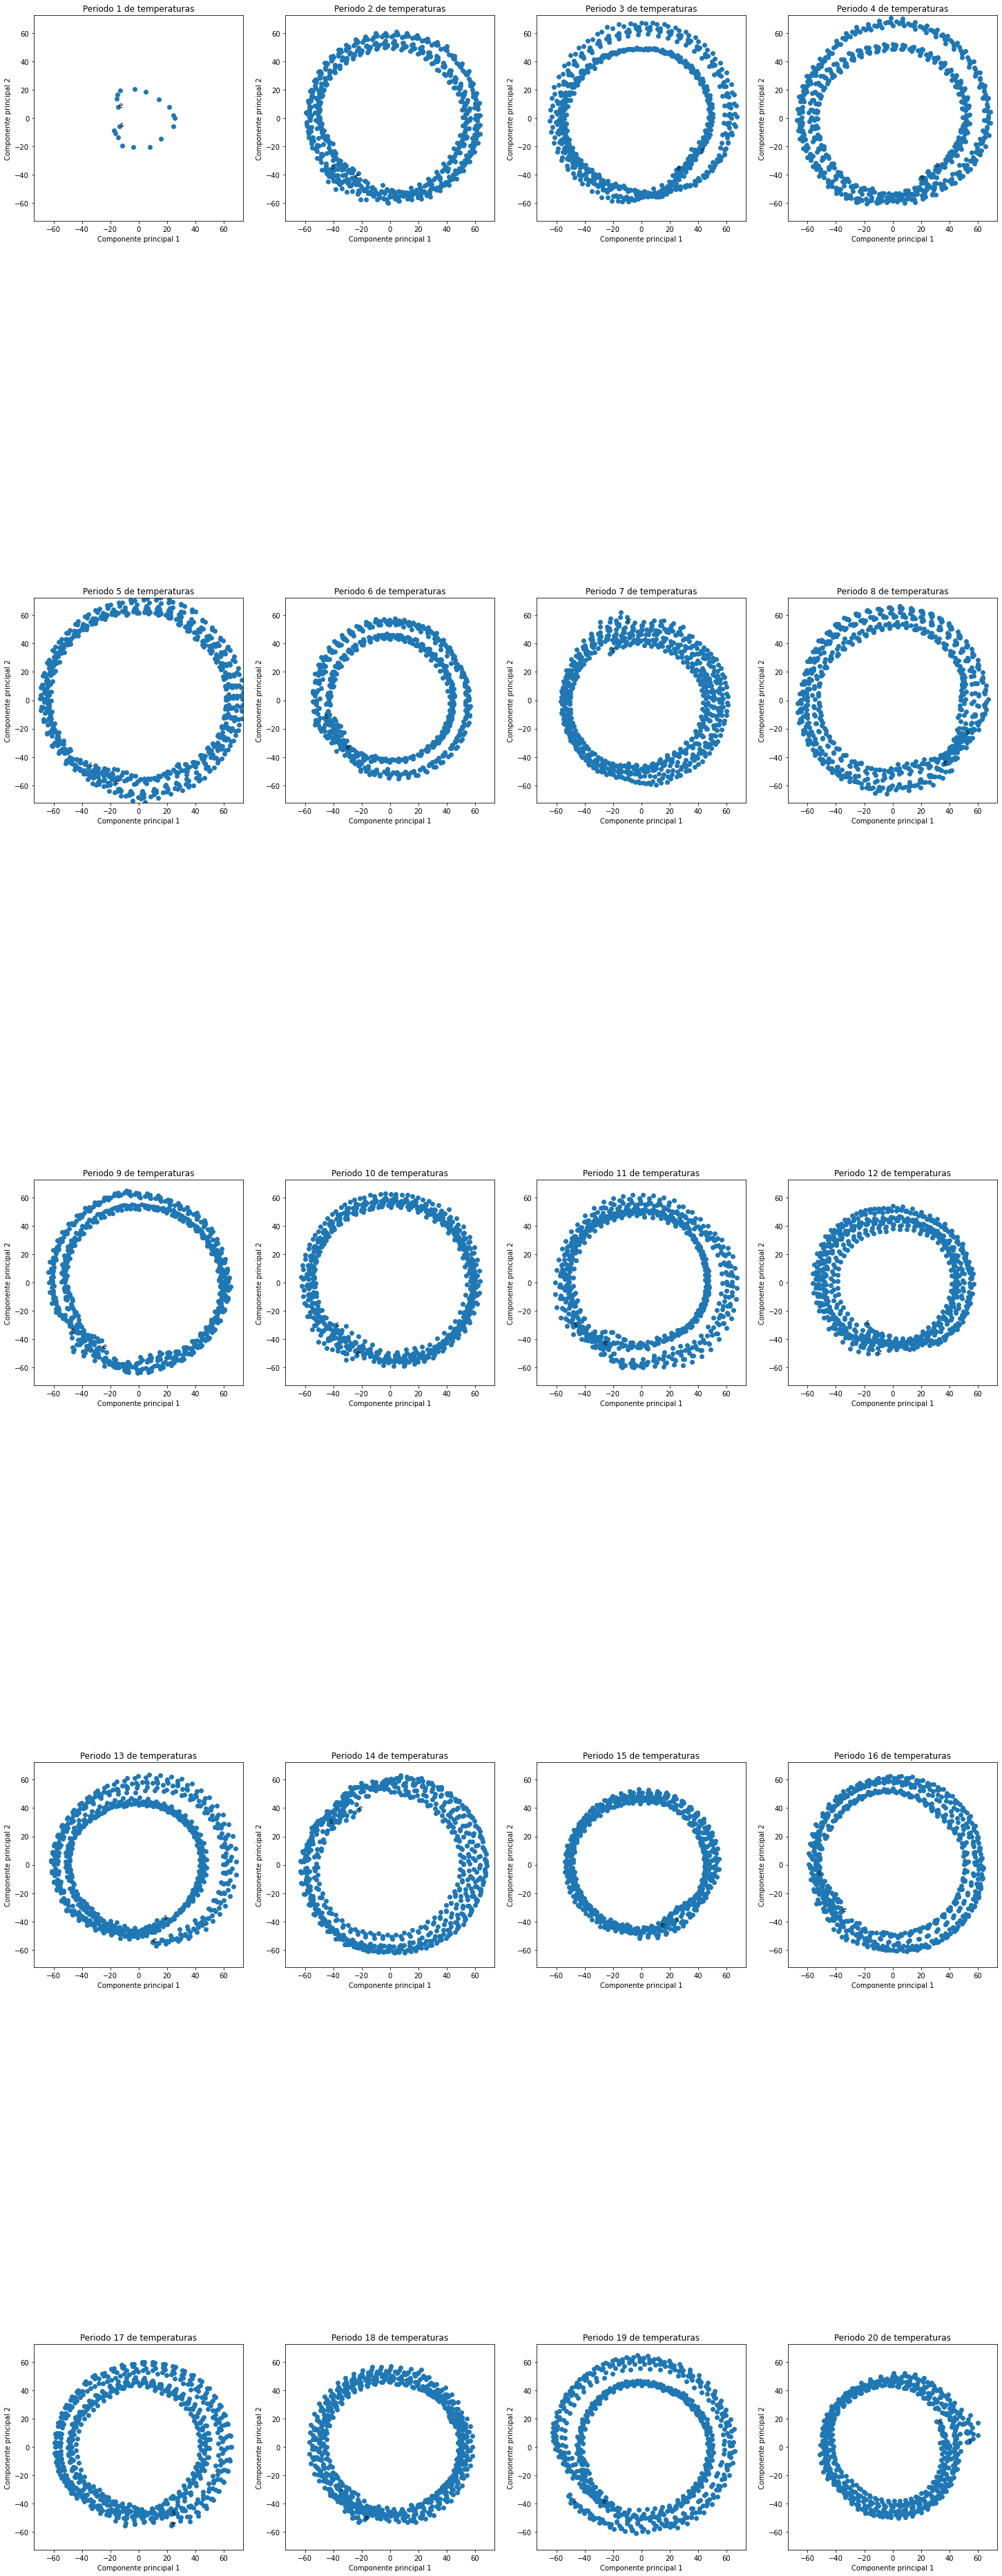

In [34]:
die2dPlotterZeug(temps2d,'temperaturas')

#### Flujos

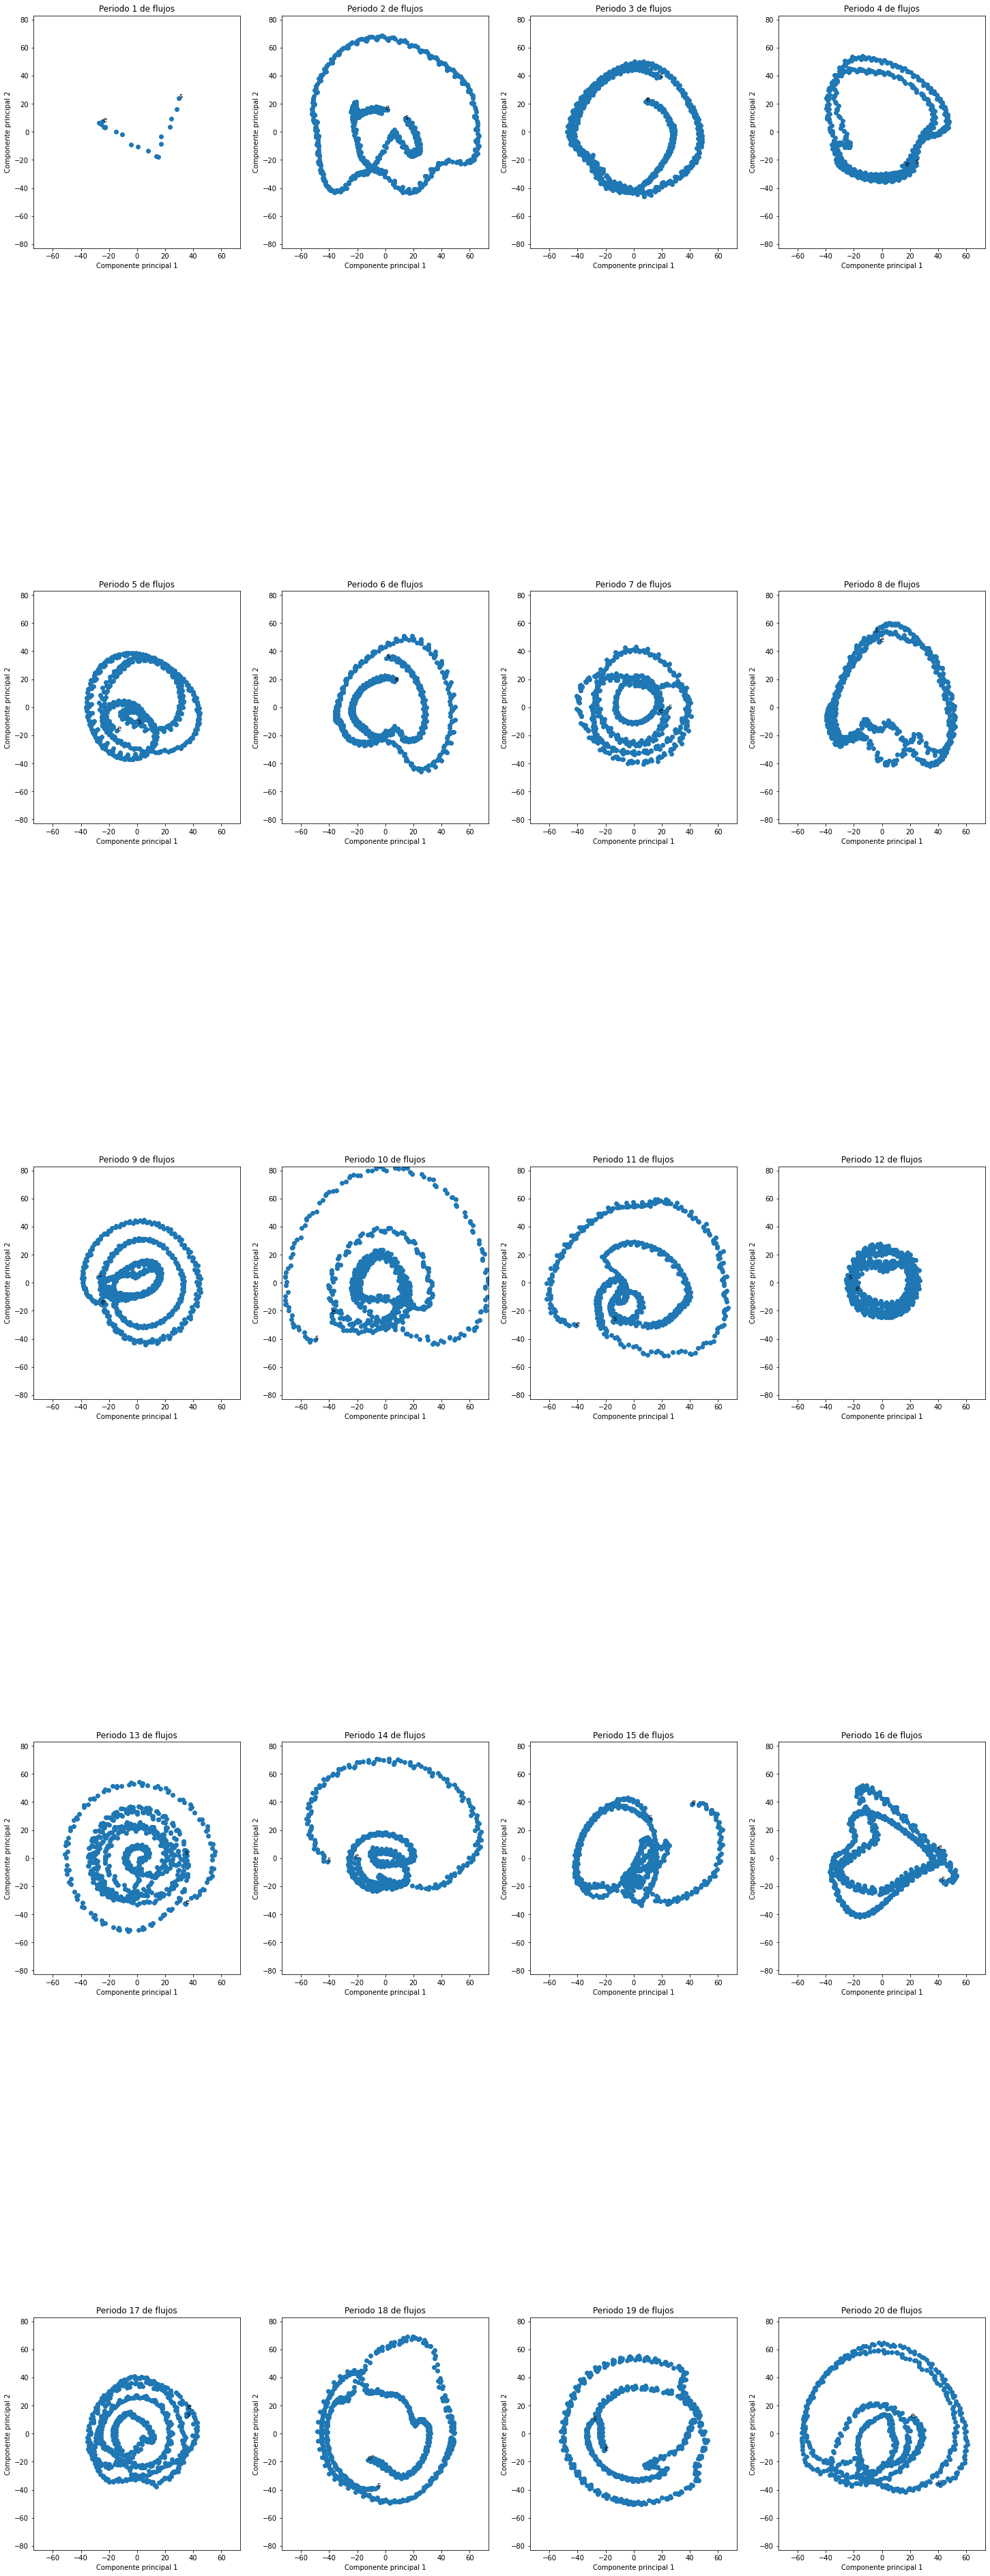

In [35]:
die2dPlotterZeug(flows2d,'flujos')

In [36]:
def centrosDeMasa2d(x: list,title:str)-> list:
  '''Obtiene los plots de los centros de masa a traves del tiempo enumerando
  cada periodo. Devuelve una lista con los centros de masa'''
  xi,yi=[],[]
  ci=np.linspace(0, 1, num=len(x))
  fig, axs = plt.subplots(figsize=(24,18))
  for i in range(len(x)):
    xi.append(x[i][:,0].mean())
    yi.append(x[i][:,1].mean())
    #axs.plot(x[i][:,0].mean(),x[i][:,1].mean(),label=i,marker=".")
  axs.scatter(xi,yi,c=ci)
  n = list(range(1,len(x)+1))
  for i, txt in enumerate(n):
    axs.annotate(txt, (xi[i], yi[i]))
  axs.set_xlabel('Componente principal 1')
  axs.set_ylabel('Componente principal 2')
  axs.set_title('Centros de masa de '+title)
  axs.set_xlim(-max(xi),max(xi))
  axs.set_ylim(-max(yi),max(yi))
  axs.set_aspect('equal','box')
  return xi,yi

In [37]:
def cambiosCentrosDeMasa2d(x: list,y: list,title:str)-> None:
  '''Obtiene los plots de los cambios en los centros de masa y anota el indice
  de cada uno'''
  fig, axs = plt.subplots(2,1,figsize=(16,12))
  axs[0].plot(np.diff(x))
  axs[0].set_xlabel('Periodo')
  axs[0].set_ylabel('Cambio en centro de masa en x')
  axs[0].set_title('Movimiento de centro de masa de '+title+' en x')
  axs[1].plot(np.diff(y))
  axs[1].set_xlabel('Periodo')
  axs[1].set_ylabel('Cambio en centro de masa en y')
  axs[1].set_title('Movimiento de centro de masa de '+title+' en y')
  plt.show()


### Centros de masa

#### Precipitaciones

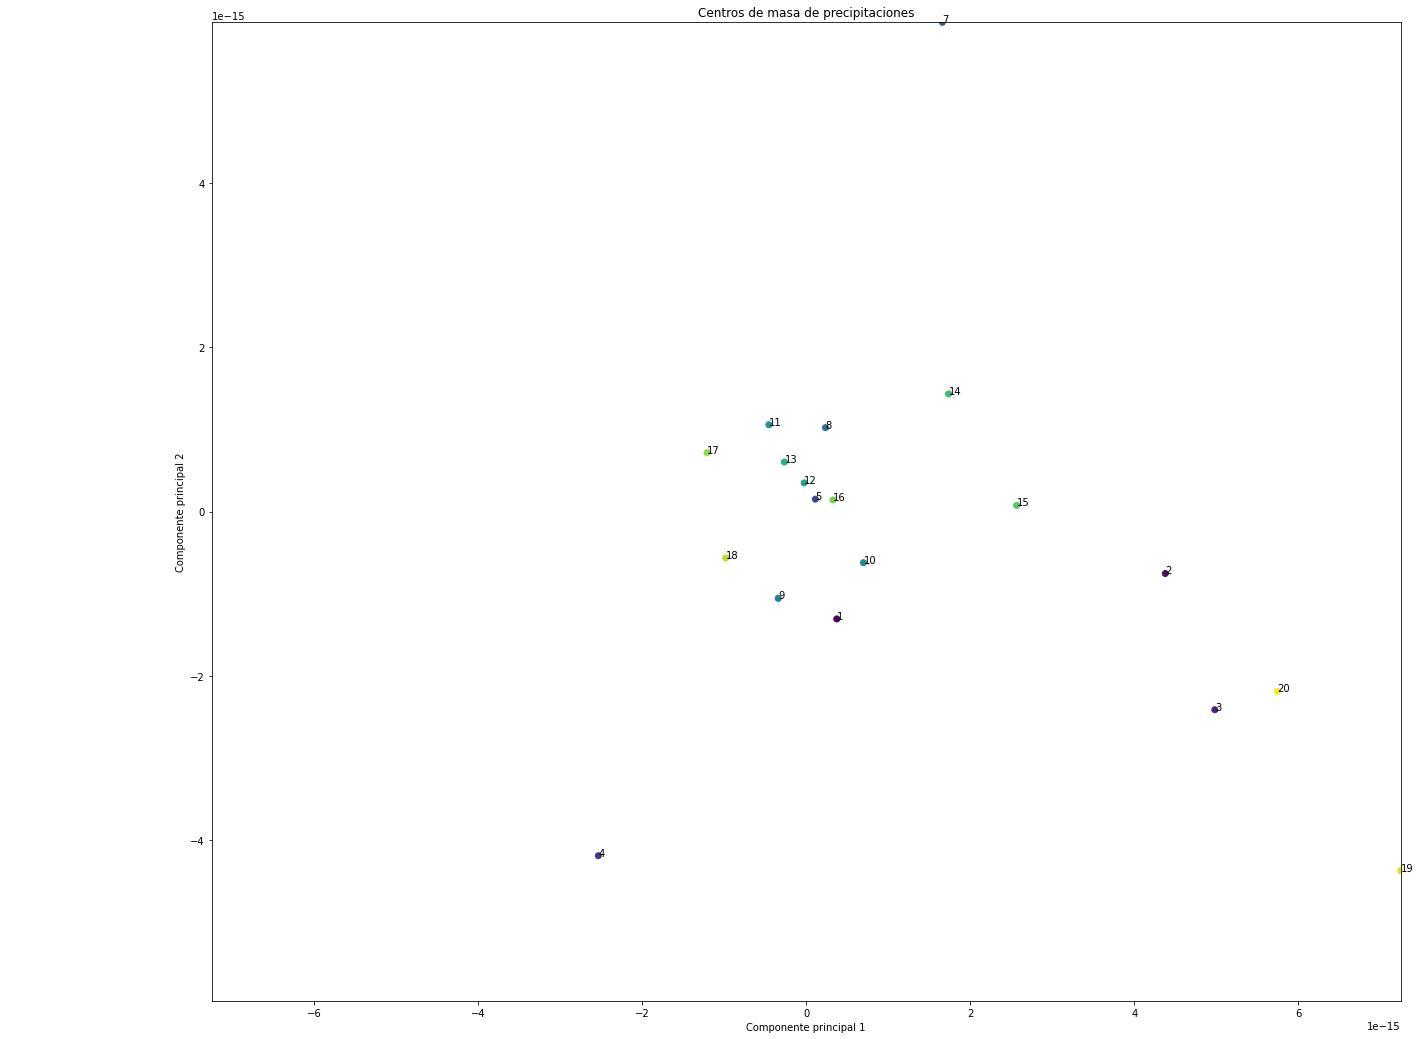

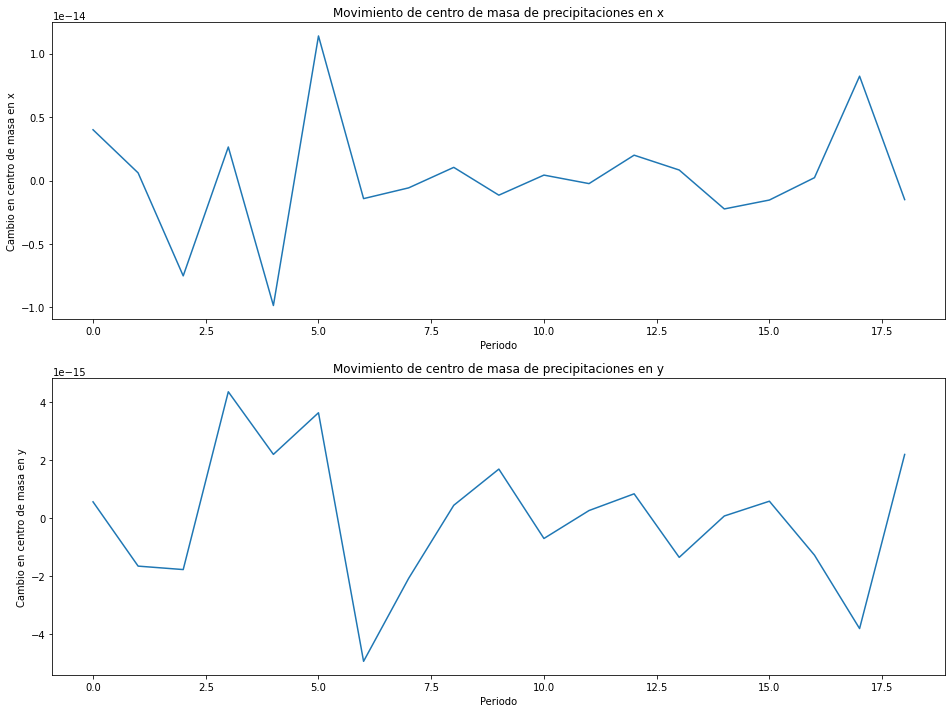

In [38]:
cmPx,cmPy = centrosDeMasa2d(precs2d,'precipitaciones')
cambiosCentrosDeMasa2d(cmPx,cmPy,'precipitaciones')

#### Temperaturas

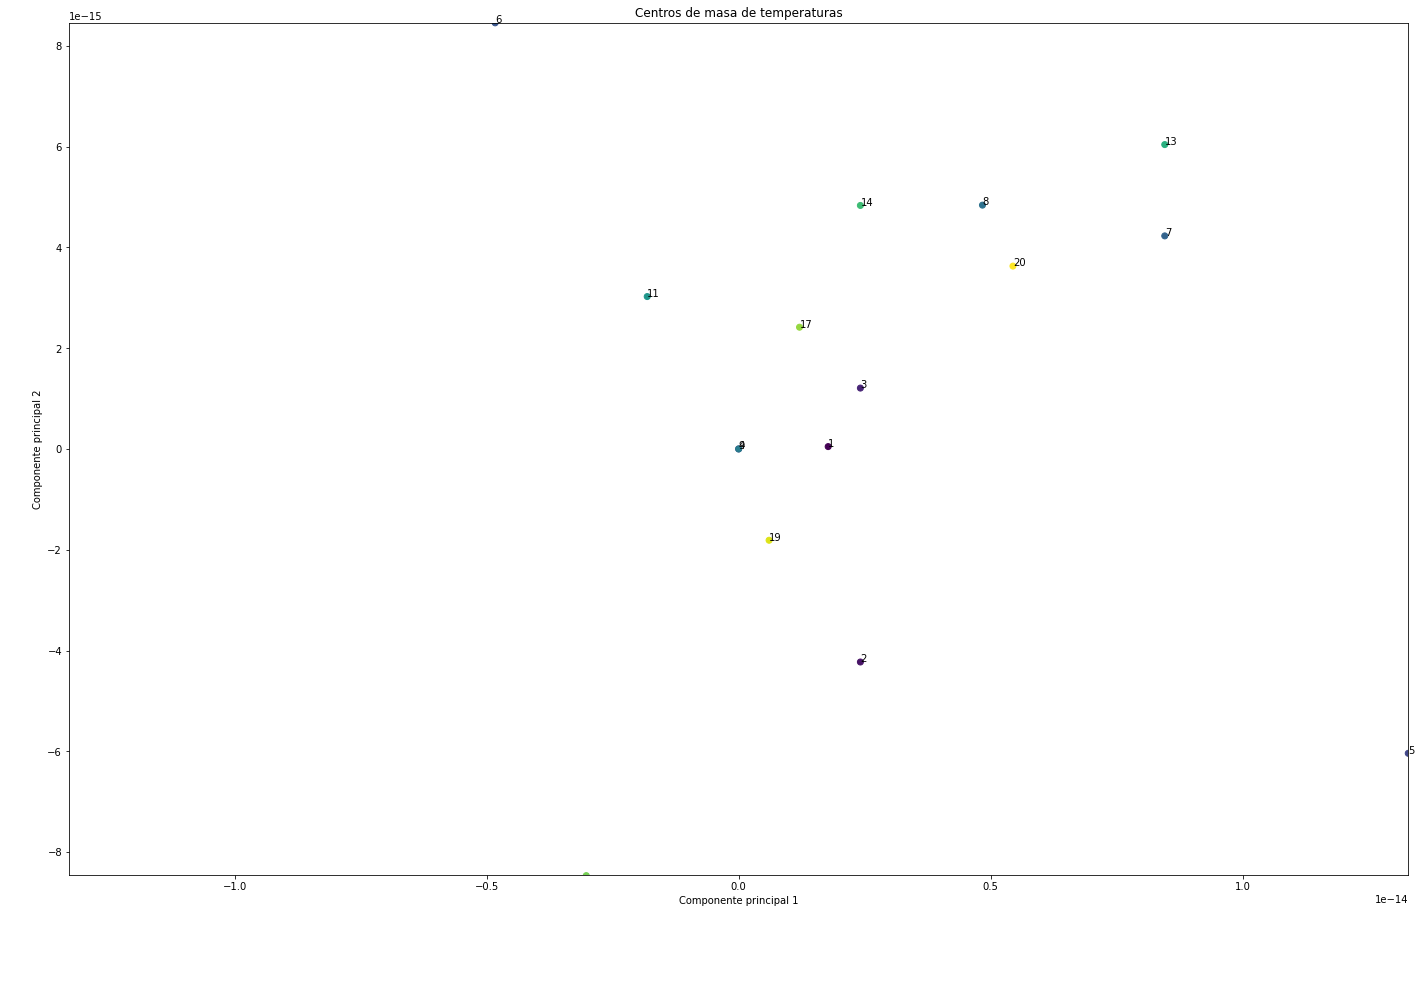

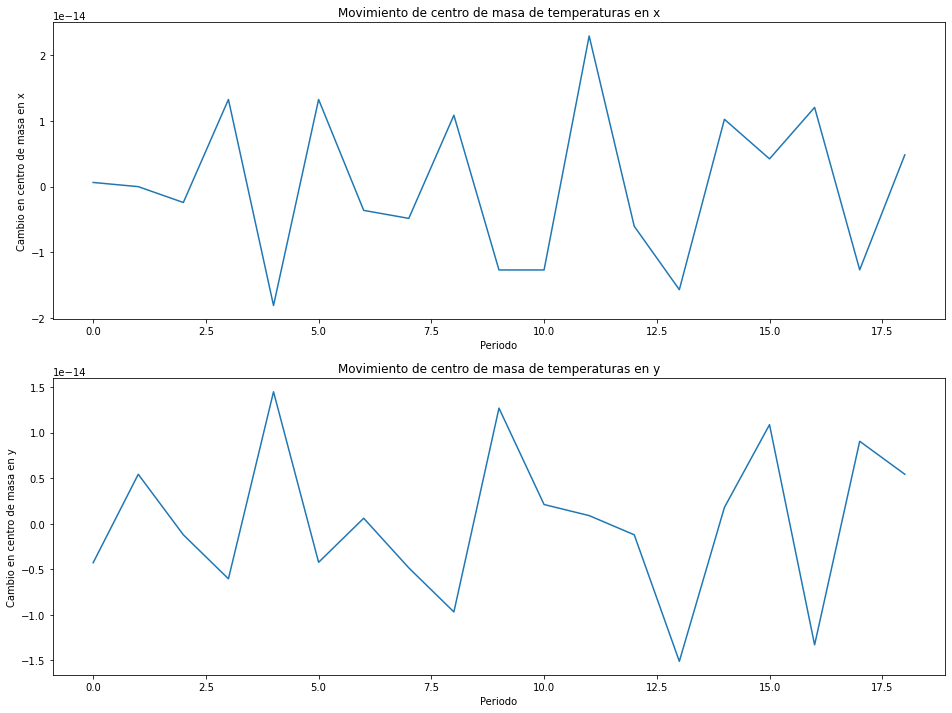

In [39]:
cmTx,cmTy = centrosDeMasa2d(temps2d,'temperaturas')
cambiosCentrosDeMasa2d(cmTx,cmTy,'temperaturas')

#### Flujos

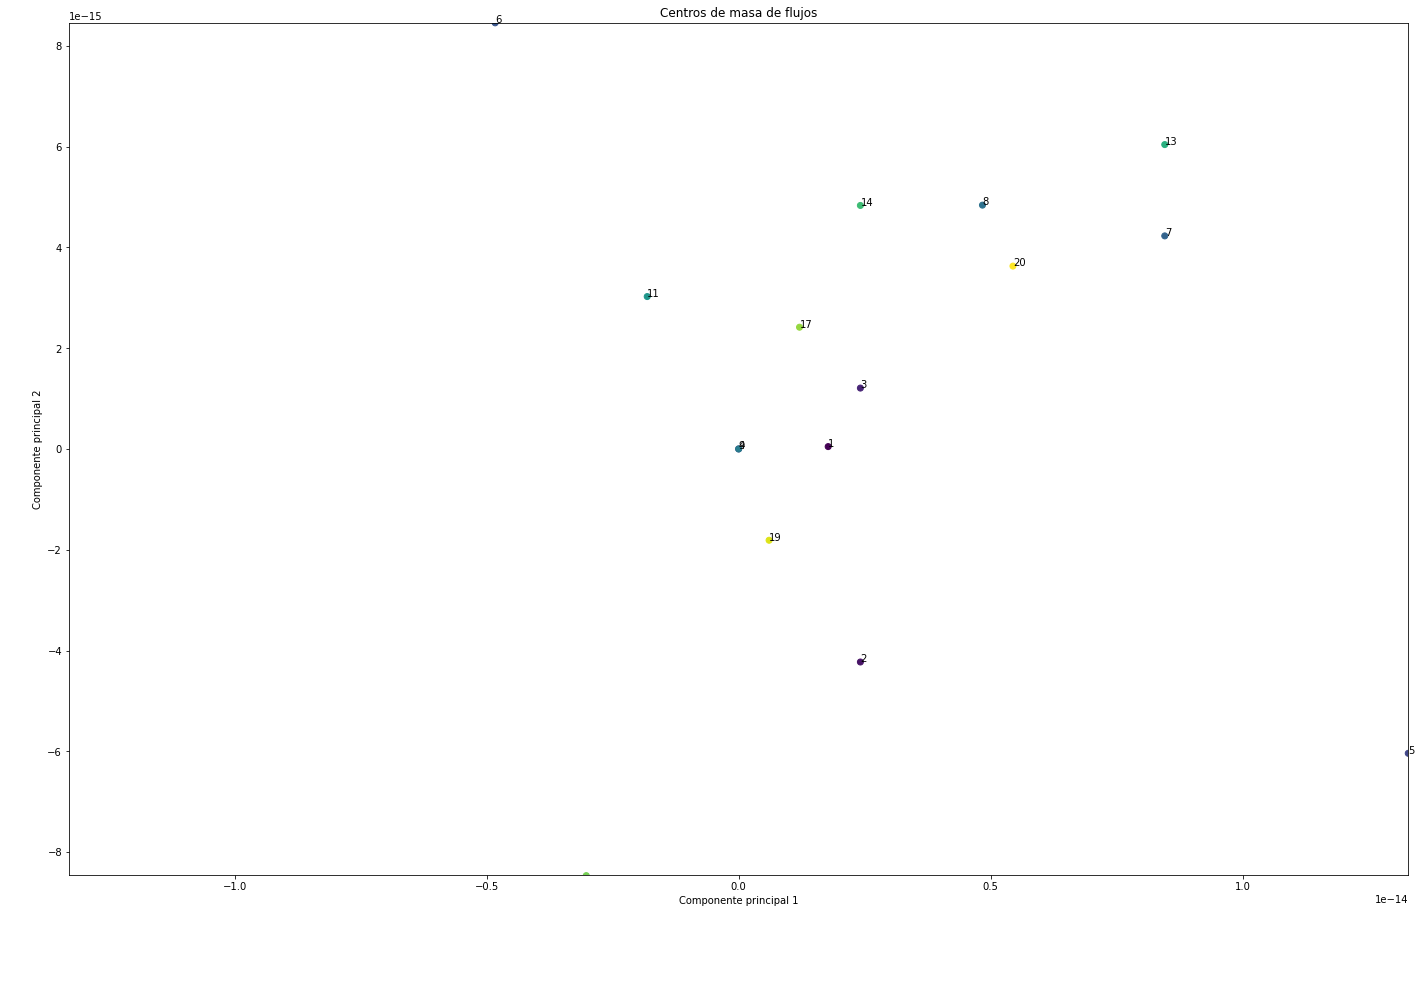

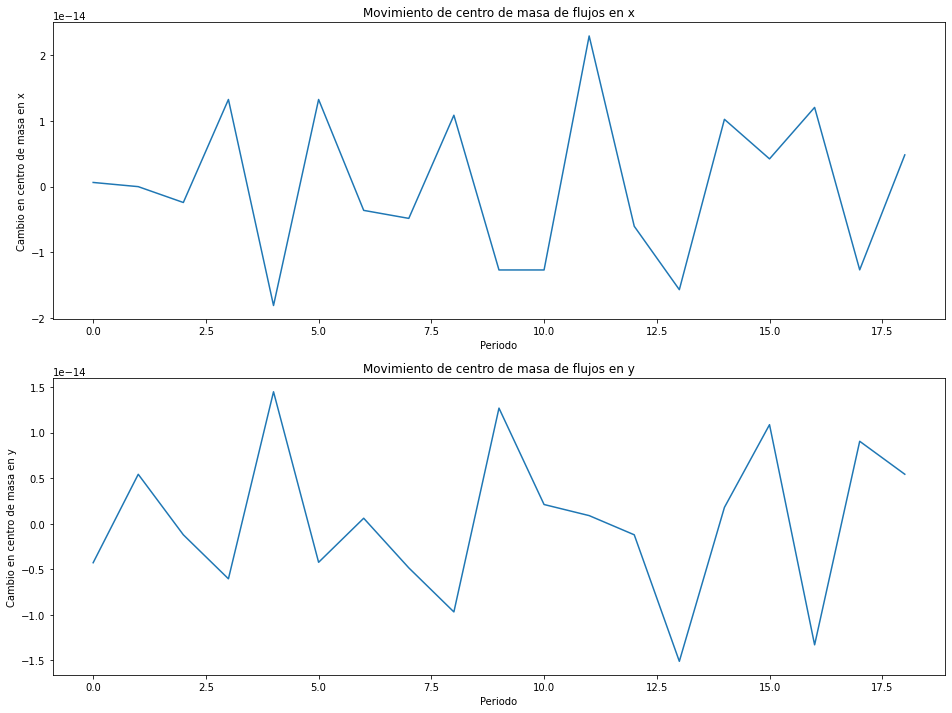

In [40]:
cmFx,cmFy = centrosDeMasa2d(temps2d,'flujos')
cambiosCentrosDeMasa2d(cmFx,cmFy,'flujos')

## TDA por años con datos suavizados con rolling means

In [41]:
def tankRolling(dfs: list) -> list:
  '''Version de tank que hace lo mismo con datos suavizados'''
  pca2 = PCA(n_components=2)
  precs2d,temps2d,flows2d=[],[],[]
  for i in range(len(dfs)):
    _,_,precipitacion_embedded = fit_embedder(embedder_PrecsSoft, dfs[i]['rolling_prec_'+str(n)],False)
    precs2d.append(pca2.fit_transform(precipitacion_embedded))
    _,_,temperatures_embedded = fit_embedder(embedder_TempsSoft, dfs[i]['rolling_temp_'+str(n)],False)
    temps2d.append(pca2.fit_transform(temperatures_embedded))
    _,_,flow_embedded = fit_embedder(embedder_FlowsSoft, dfs[i]['rolling_flow_'+str(n)],False)
    flows2d.append(pca2.fit_transform(flow_embedded))
  return precs2d,temps2d,flows2d

In [42]:
def roller(df: pd.DataFrame,n: int=3):
  '''Calcula la media movil de las 3 variables del dataframe a n periodos'''
  df[['rolling_flow_'+str(n),'rolling_temp_'+str(n),
                       'rolling_prec_'+str(n)]] =df[['flow',
                        'temperatures','precipitations']].rolling(n).mean()
  return df

In [43]:
n=3
suavecito_suavecito=roller(df_final,n)

In [44]:
yearsSoft=el_Quique_500(suavecito_suavecito)

Se sueltan las observaciones que se pierden por el calculo de los promedios moviles el primer año

In [45]:
yearsSoft[0]=yearsSoft[0].dropna()

In [46]:
x,y,z=[],[],[]

for i in range(len(yearsSoft)):
  x1,y1,_ = fit_embedder(embedder_periodic, yearsSoft[i]['rolling_prec_'+str(n)],False)
  x2,y2,_ = fit_embedder(embedder_periodic, yearsSoft[i]['rolling_temp_'+str(n)],False)
  x3,y3,_ = fit_embedder(embedder_periodic, yearsSoft[i]['rolling_flow_'+str(n)].astype('float32'),False) 
  x.append((x1,y1))
  y.append((x2,y2))
  z.append((x3,y3))

x1=int(mode(x)[0][0][0])
y1=int(mode(x)[0][0][1])
x2=int(mode(y)[0][0][0])
y2=int(mode(y)[0][0][1])
x3=int(mode(z)[0][0][0])
y3=int(mode(z)[0][0][1])


In [47]:
embedder_PrecsSoft = SingleTakensEmbedding(
    parameters_type="fixed",
    time_delay=y1,
    dimension=x1,
    stride=stride,
)
embedder_TempsSoft = SingleTakensEmbedding(
    parameters_type="fixed",
    time_delay=y2,
    dimension=x2,
    stride=stride,
)
embedder_FlowsSoft = SingleTakensEmbedding(
    parameters_type="fixed",
    time_delay=y3,
    dimension=x3,
    stride=stride,
)

In [48]:
precs2d,temps2d,flows2d=tankRolling(yearsSoft)

### Encajes bidimensionales de datos suavizados

#### Precipitaciones

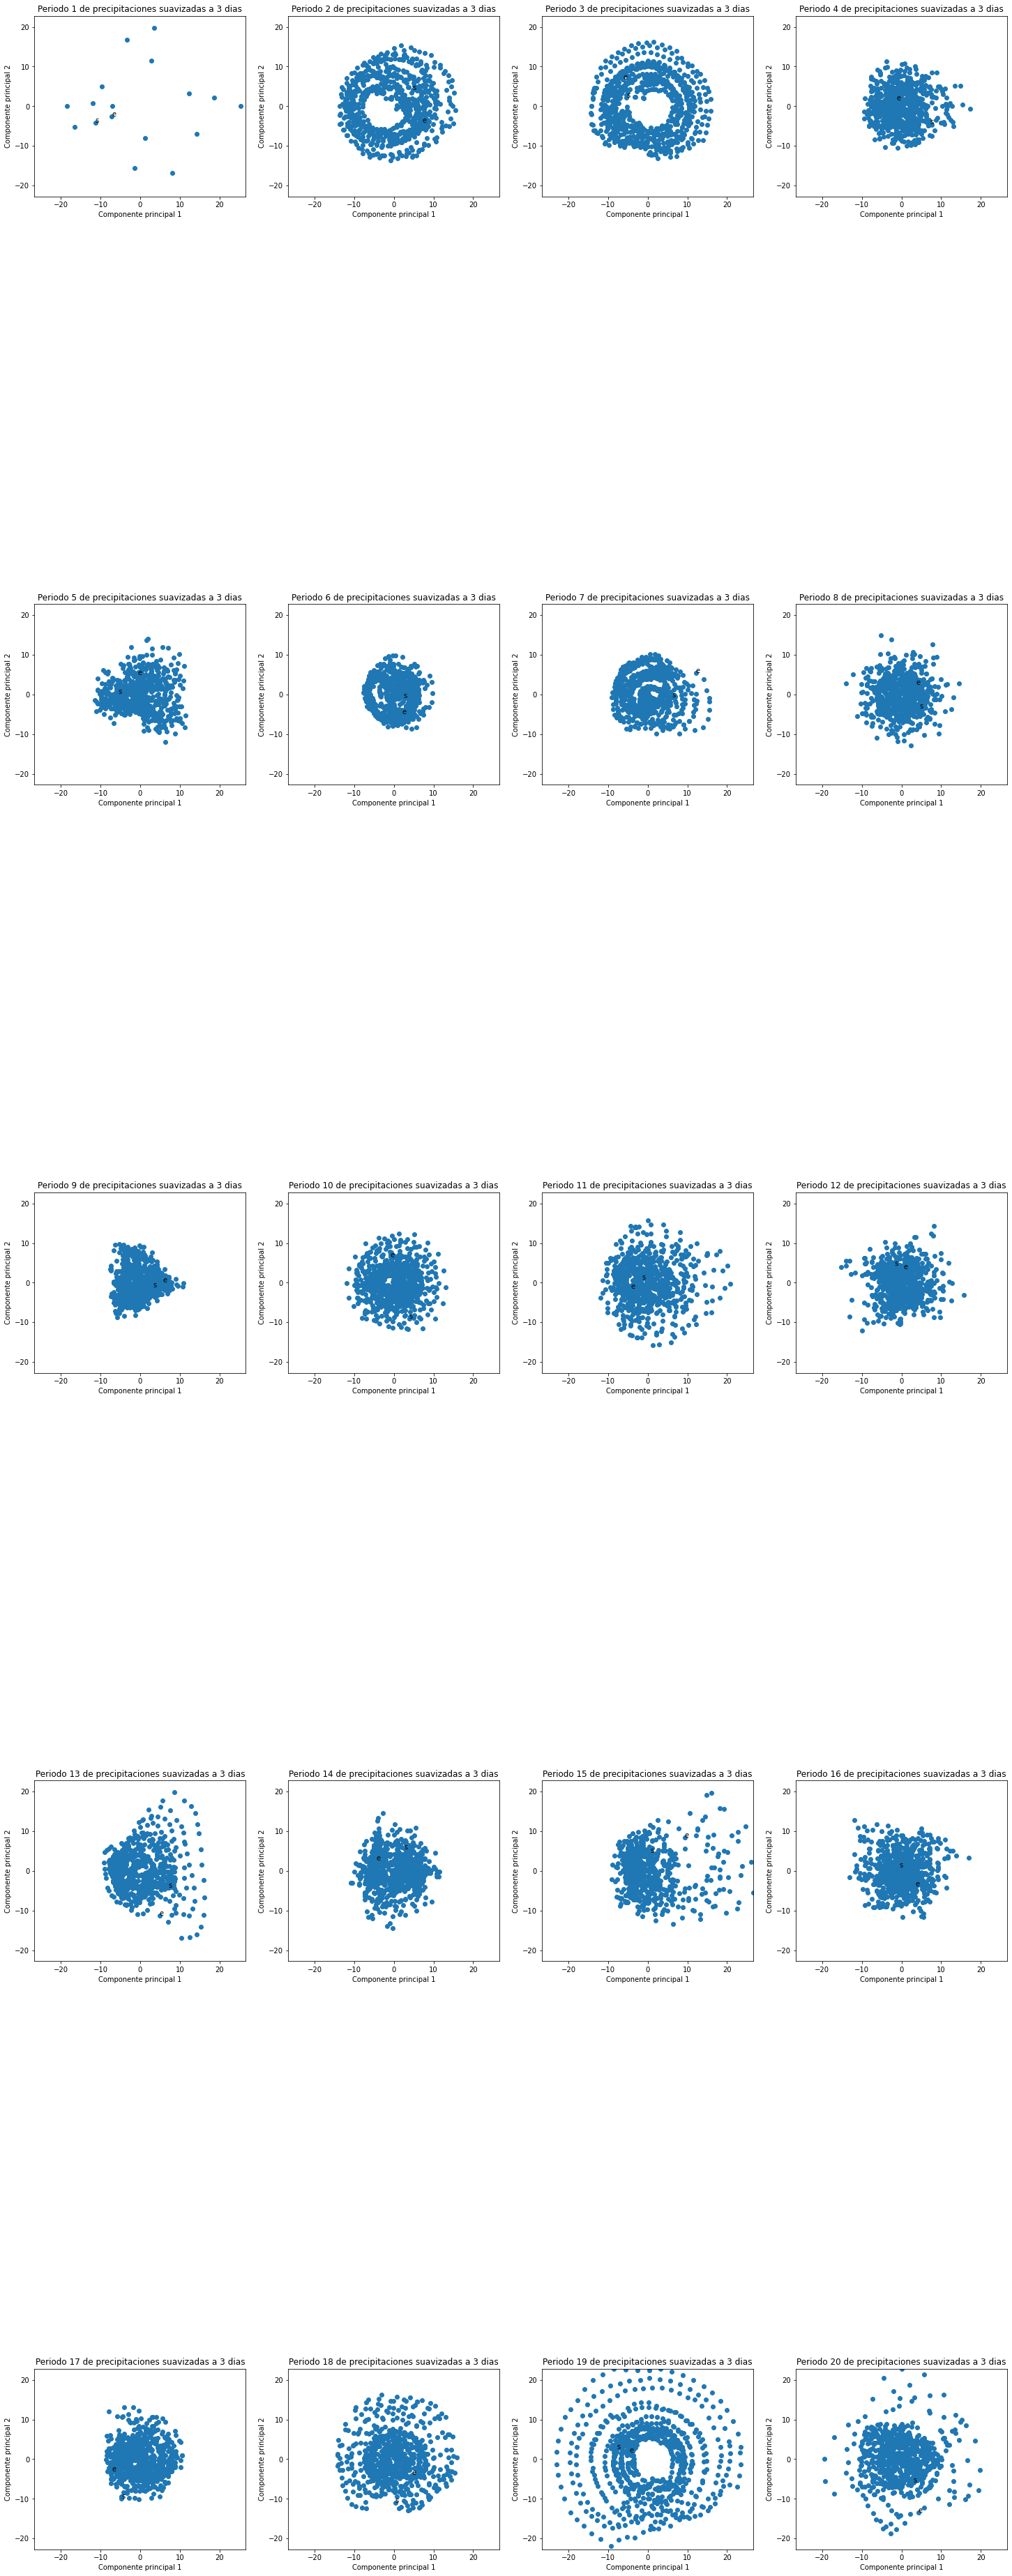

In [49]:
die2dPlotterZeug(precs2d,'precipitaciones suavizadas a '+str(n)+' dias')

#### Temperaturas

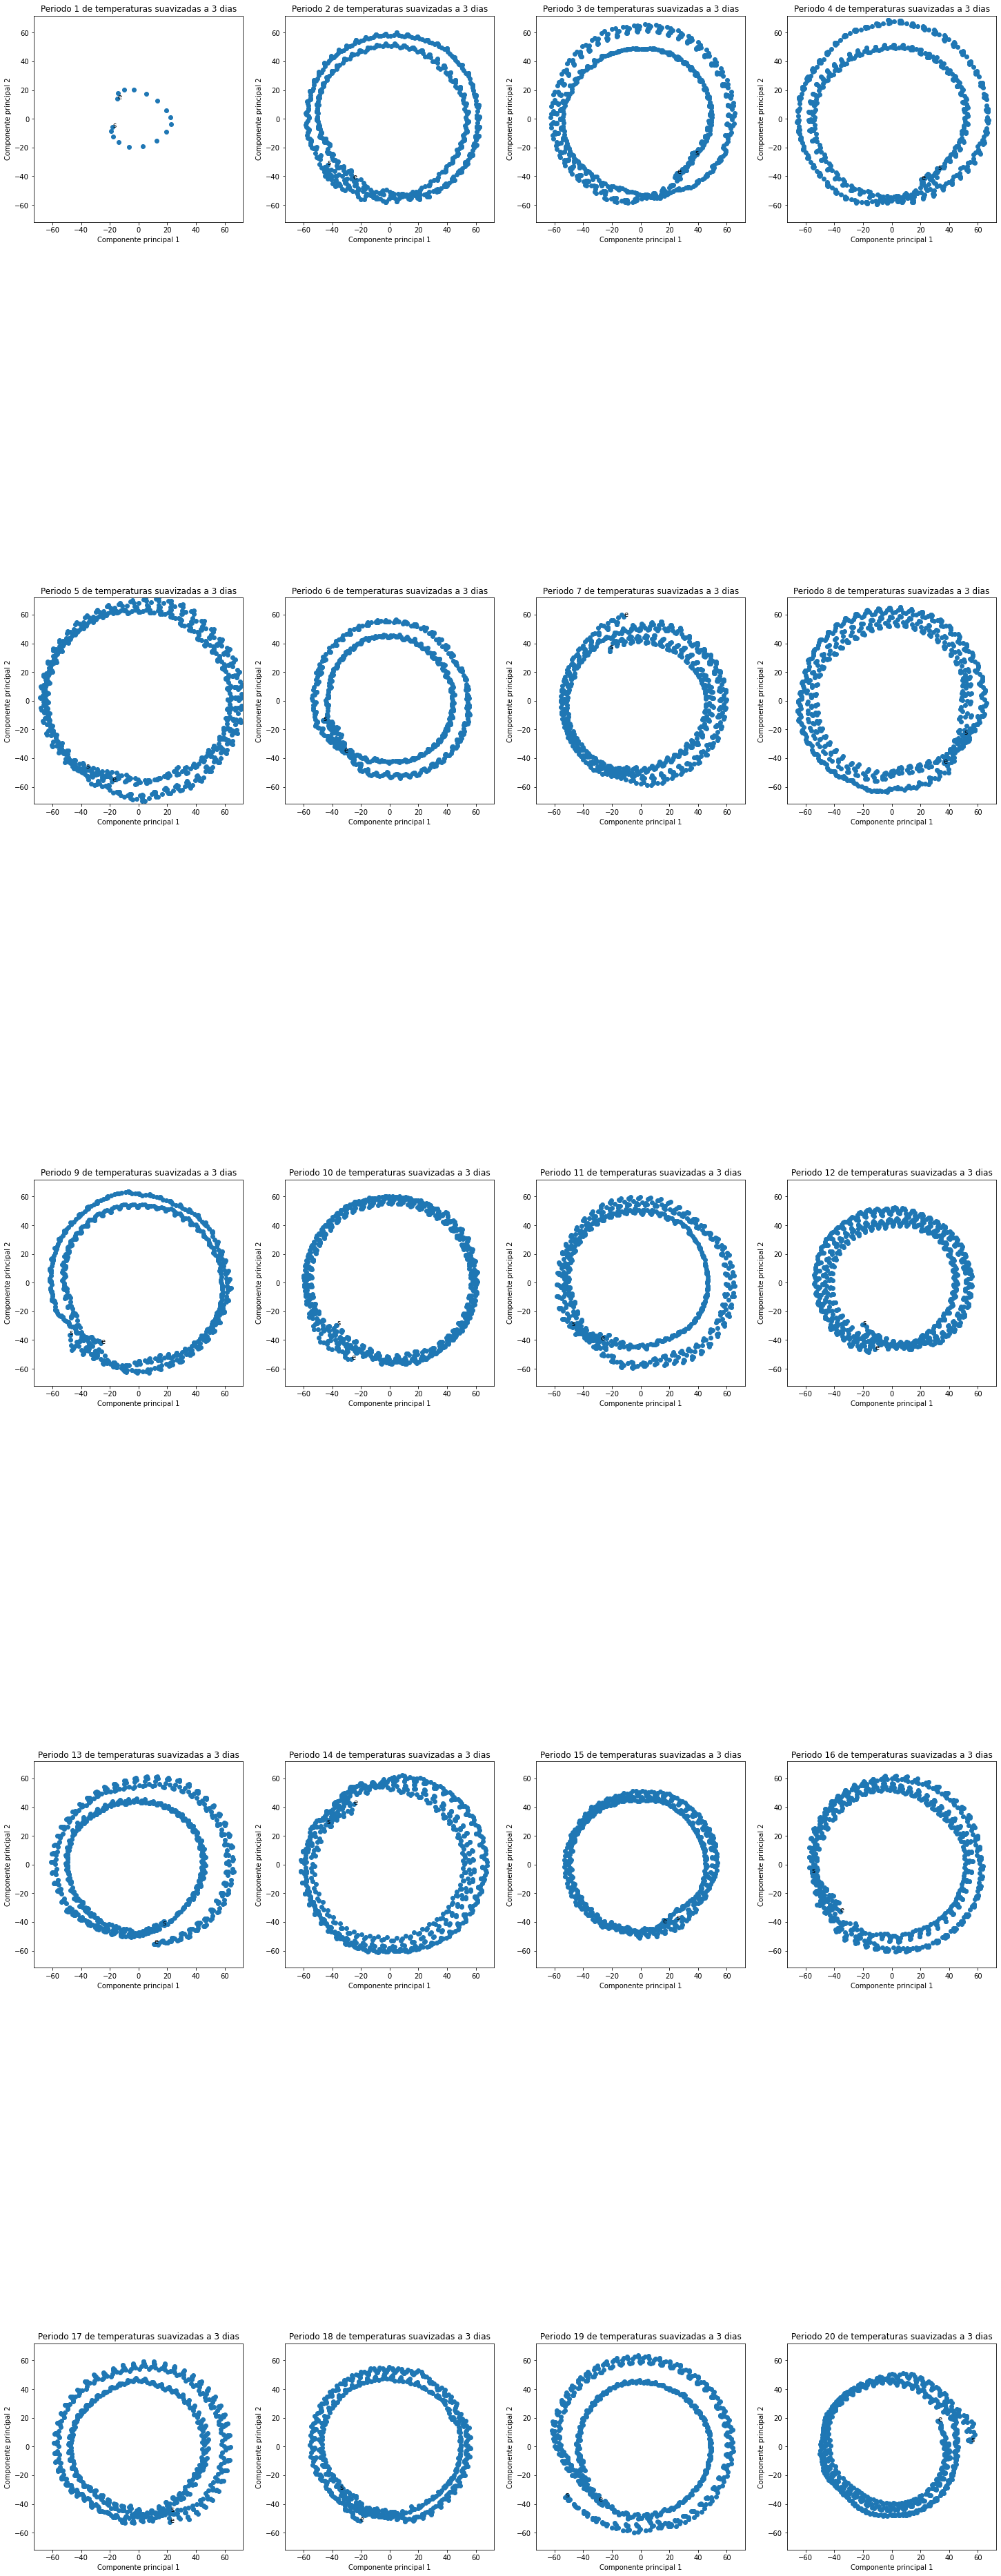

In [50]:
die2dPlotterZeug(temps2d,'temperaturas suavizadas a '+str(n)+' dias')

#### Flujos

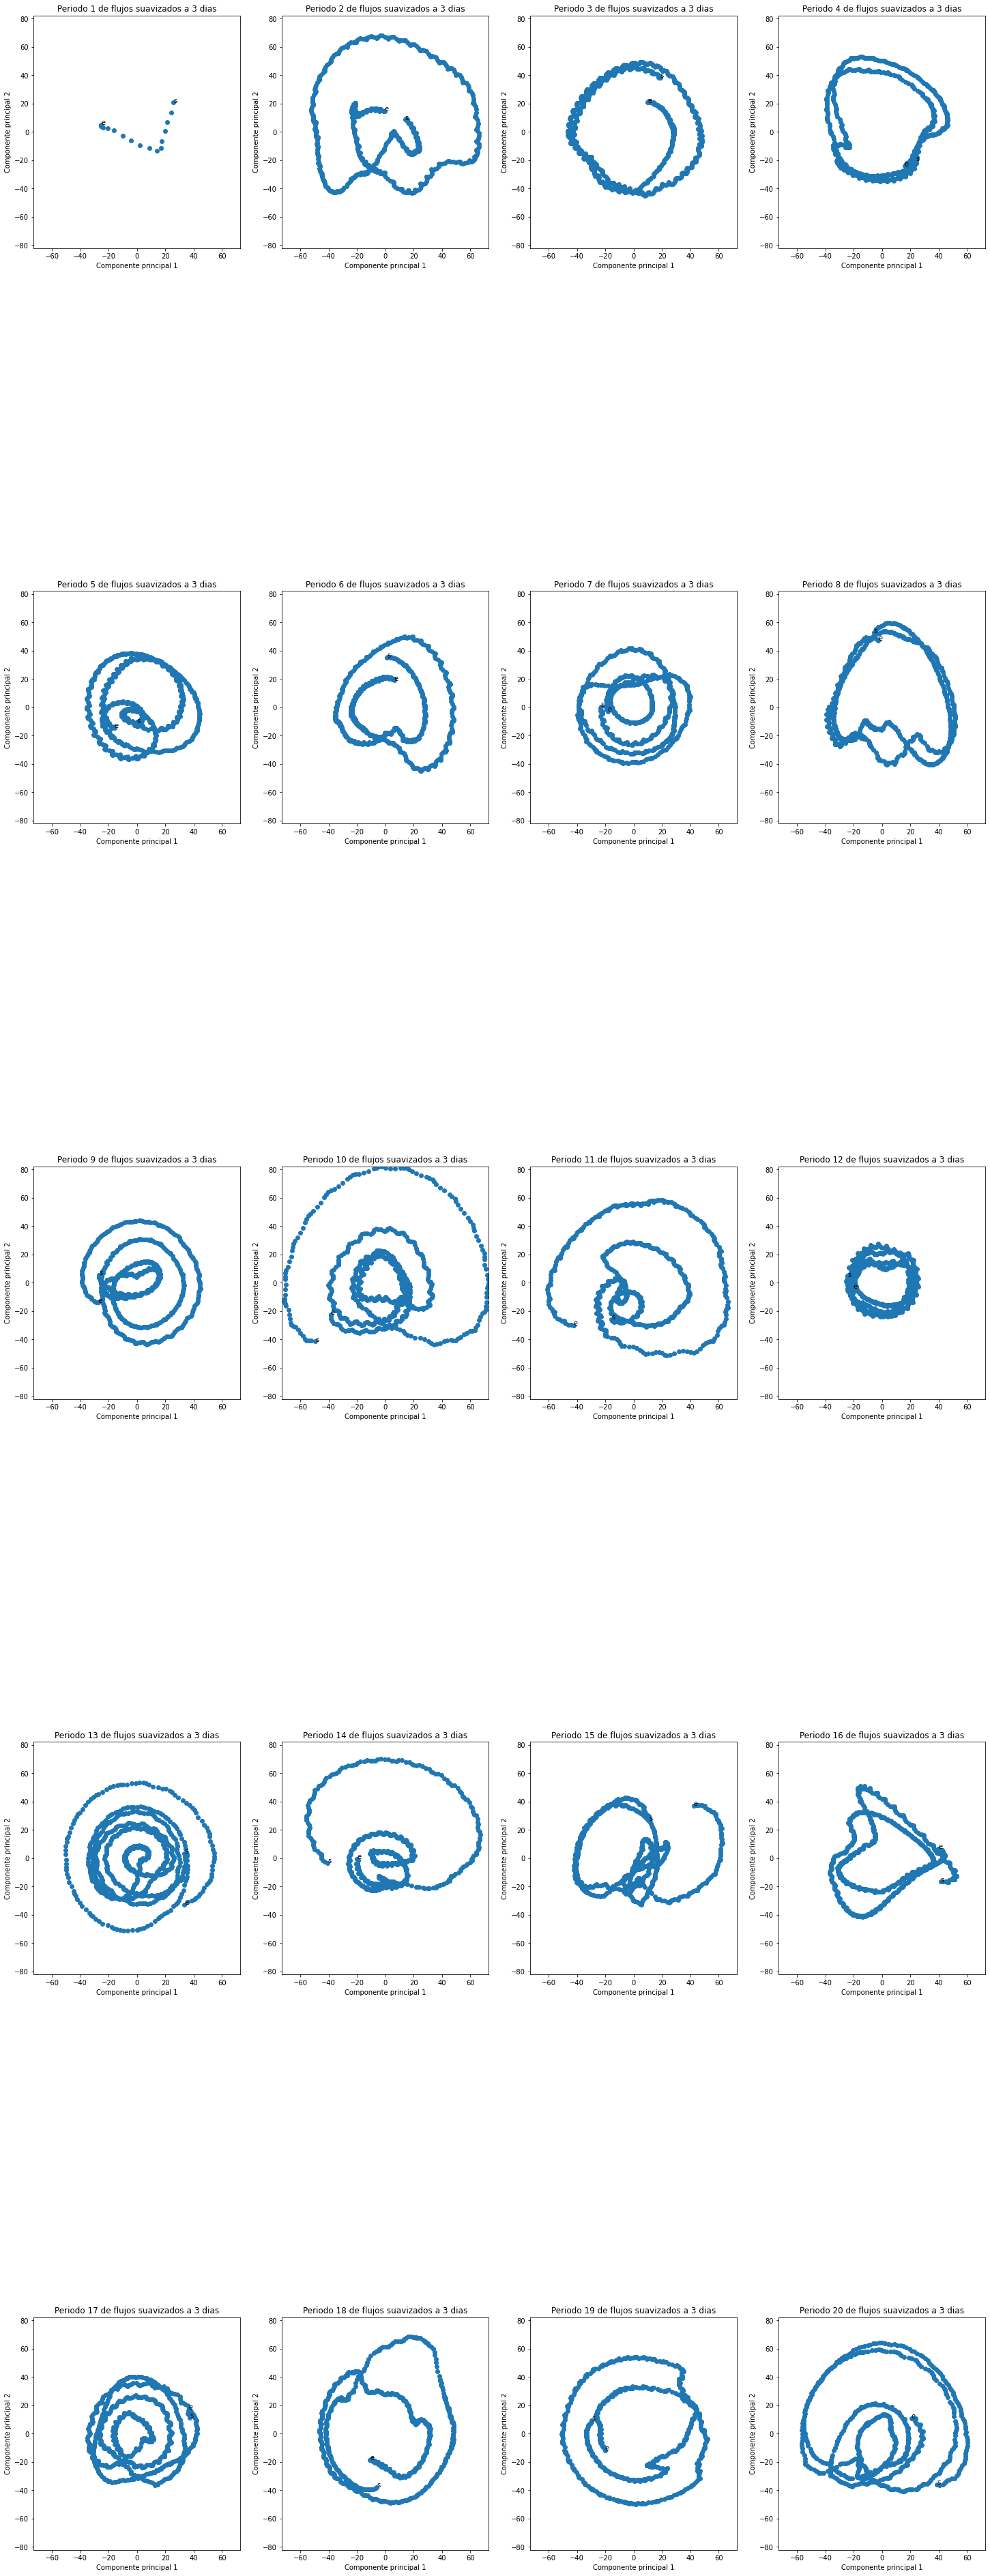

In [51]:
die2dPlotterZeug(flows2d,'flujos suavizados a '+str(n)+' dias')

### Centros de masa 

#### Precipitaciones

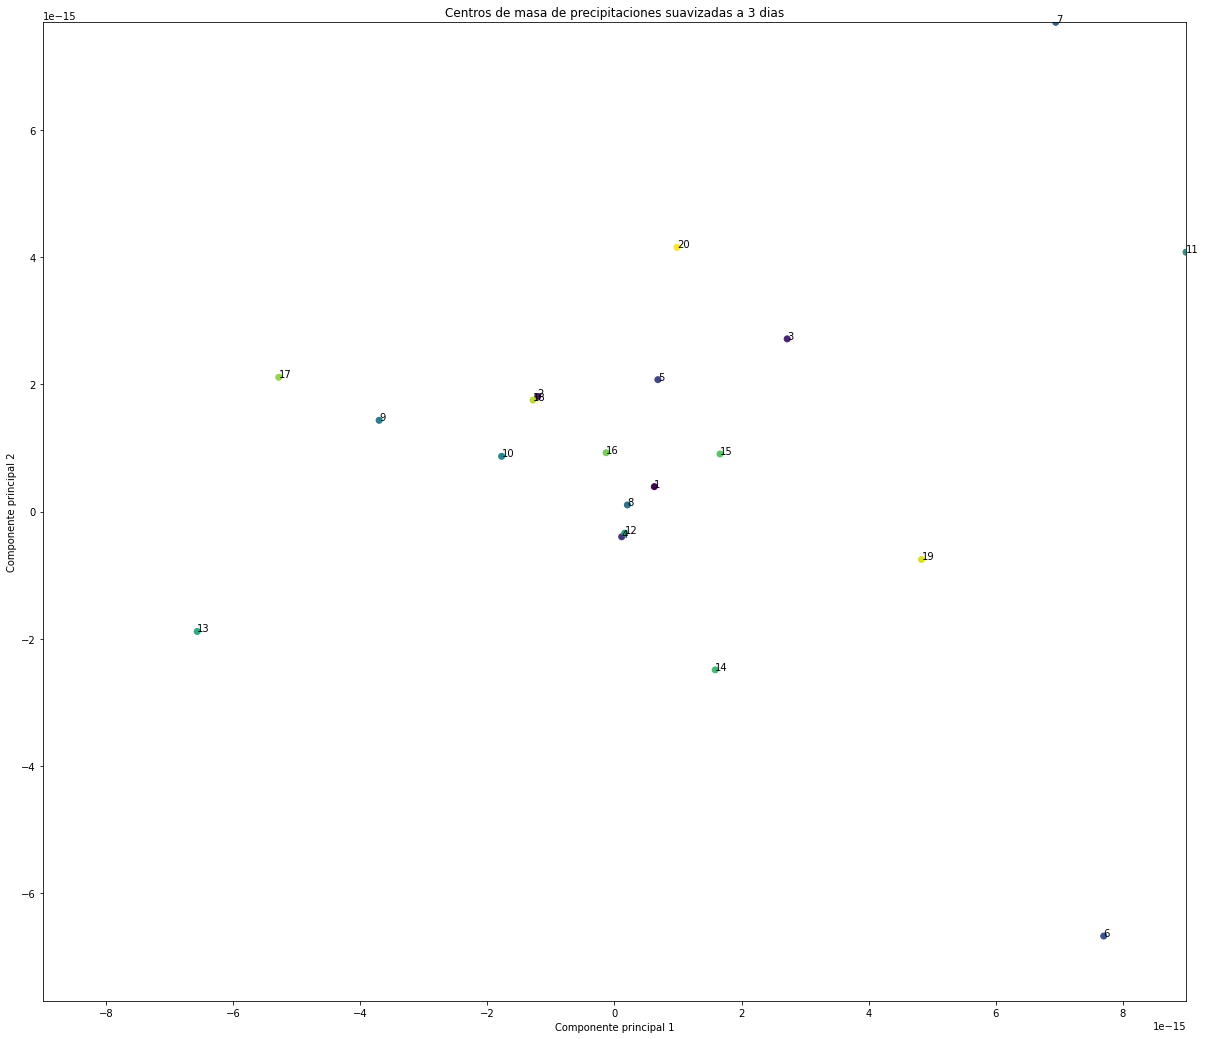

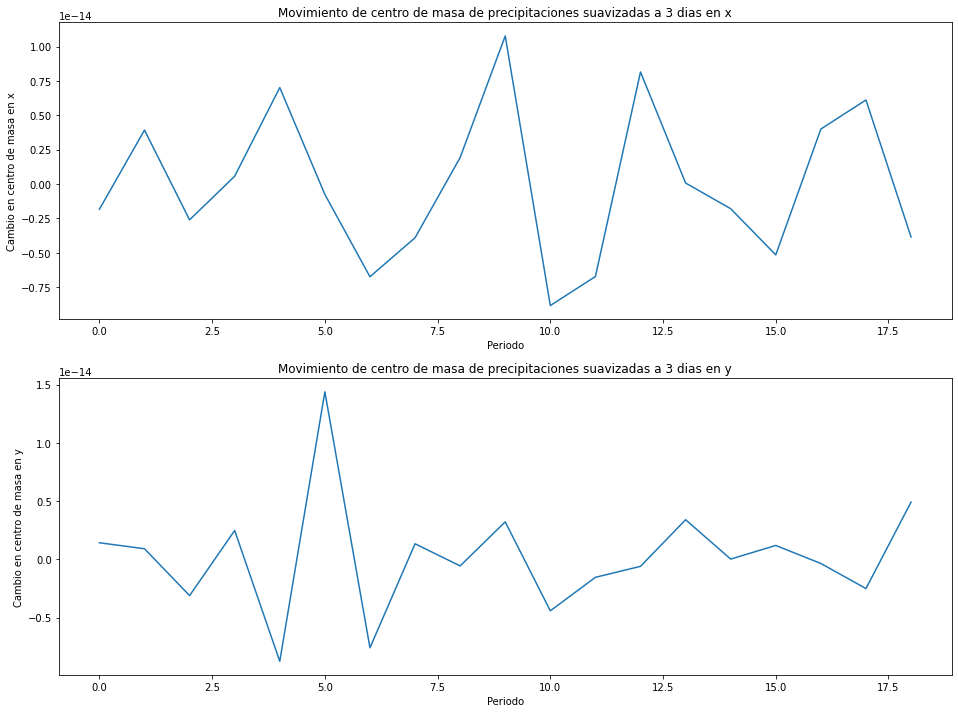

In [52]:
cmPx,cmPy=centrosDeMasa2d(precs2d,'precipitaciones suavizadas a '+str(n)+' dias')
cambiosCentrosDeMasa2d(cmPx,cmPy,'precipitaciones suavizadas a '+str(n)+' dias')

#### Temperaturas

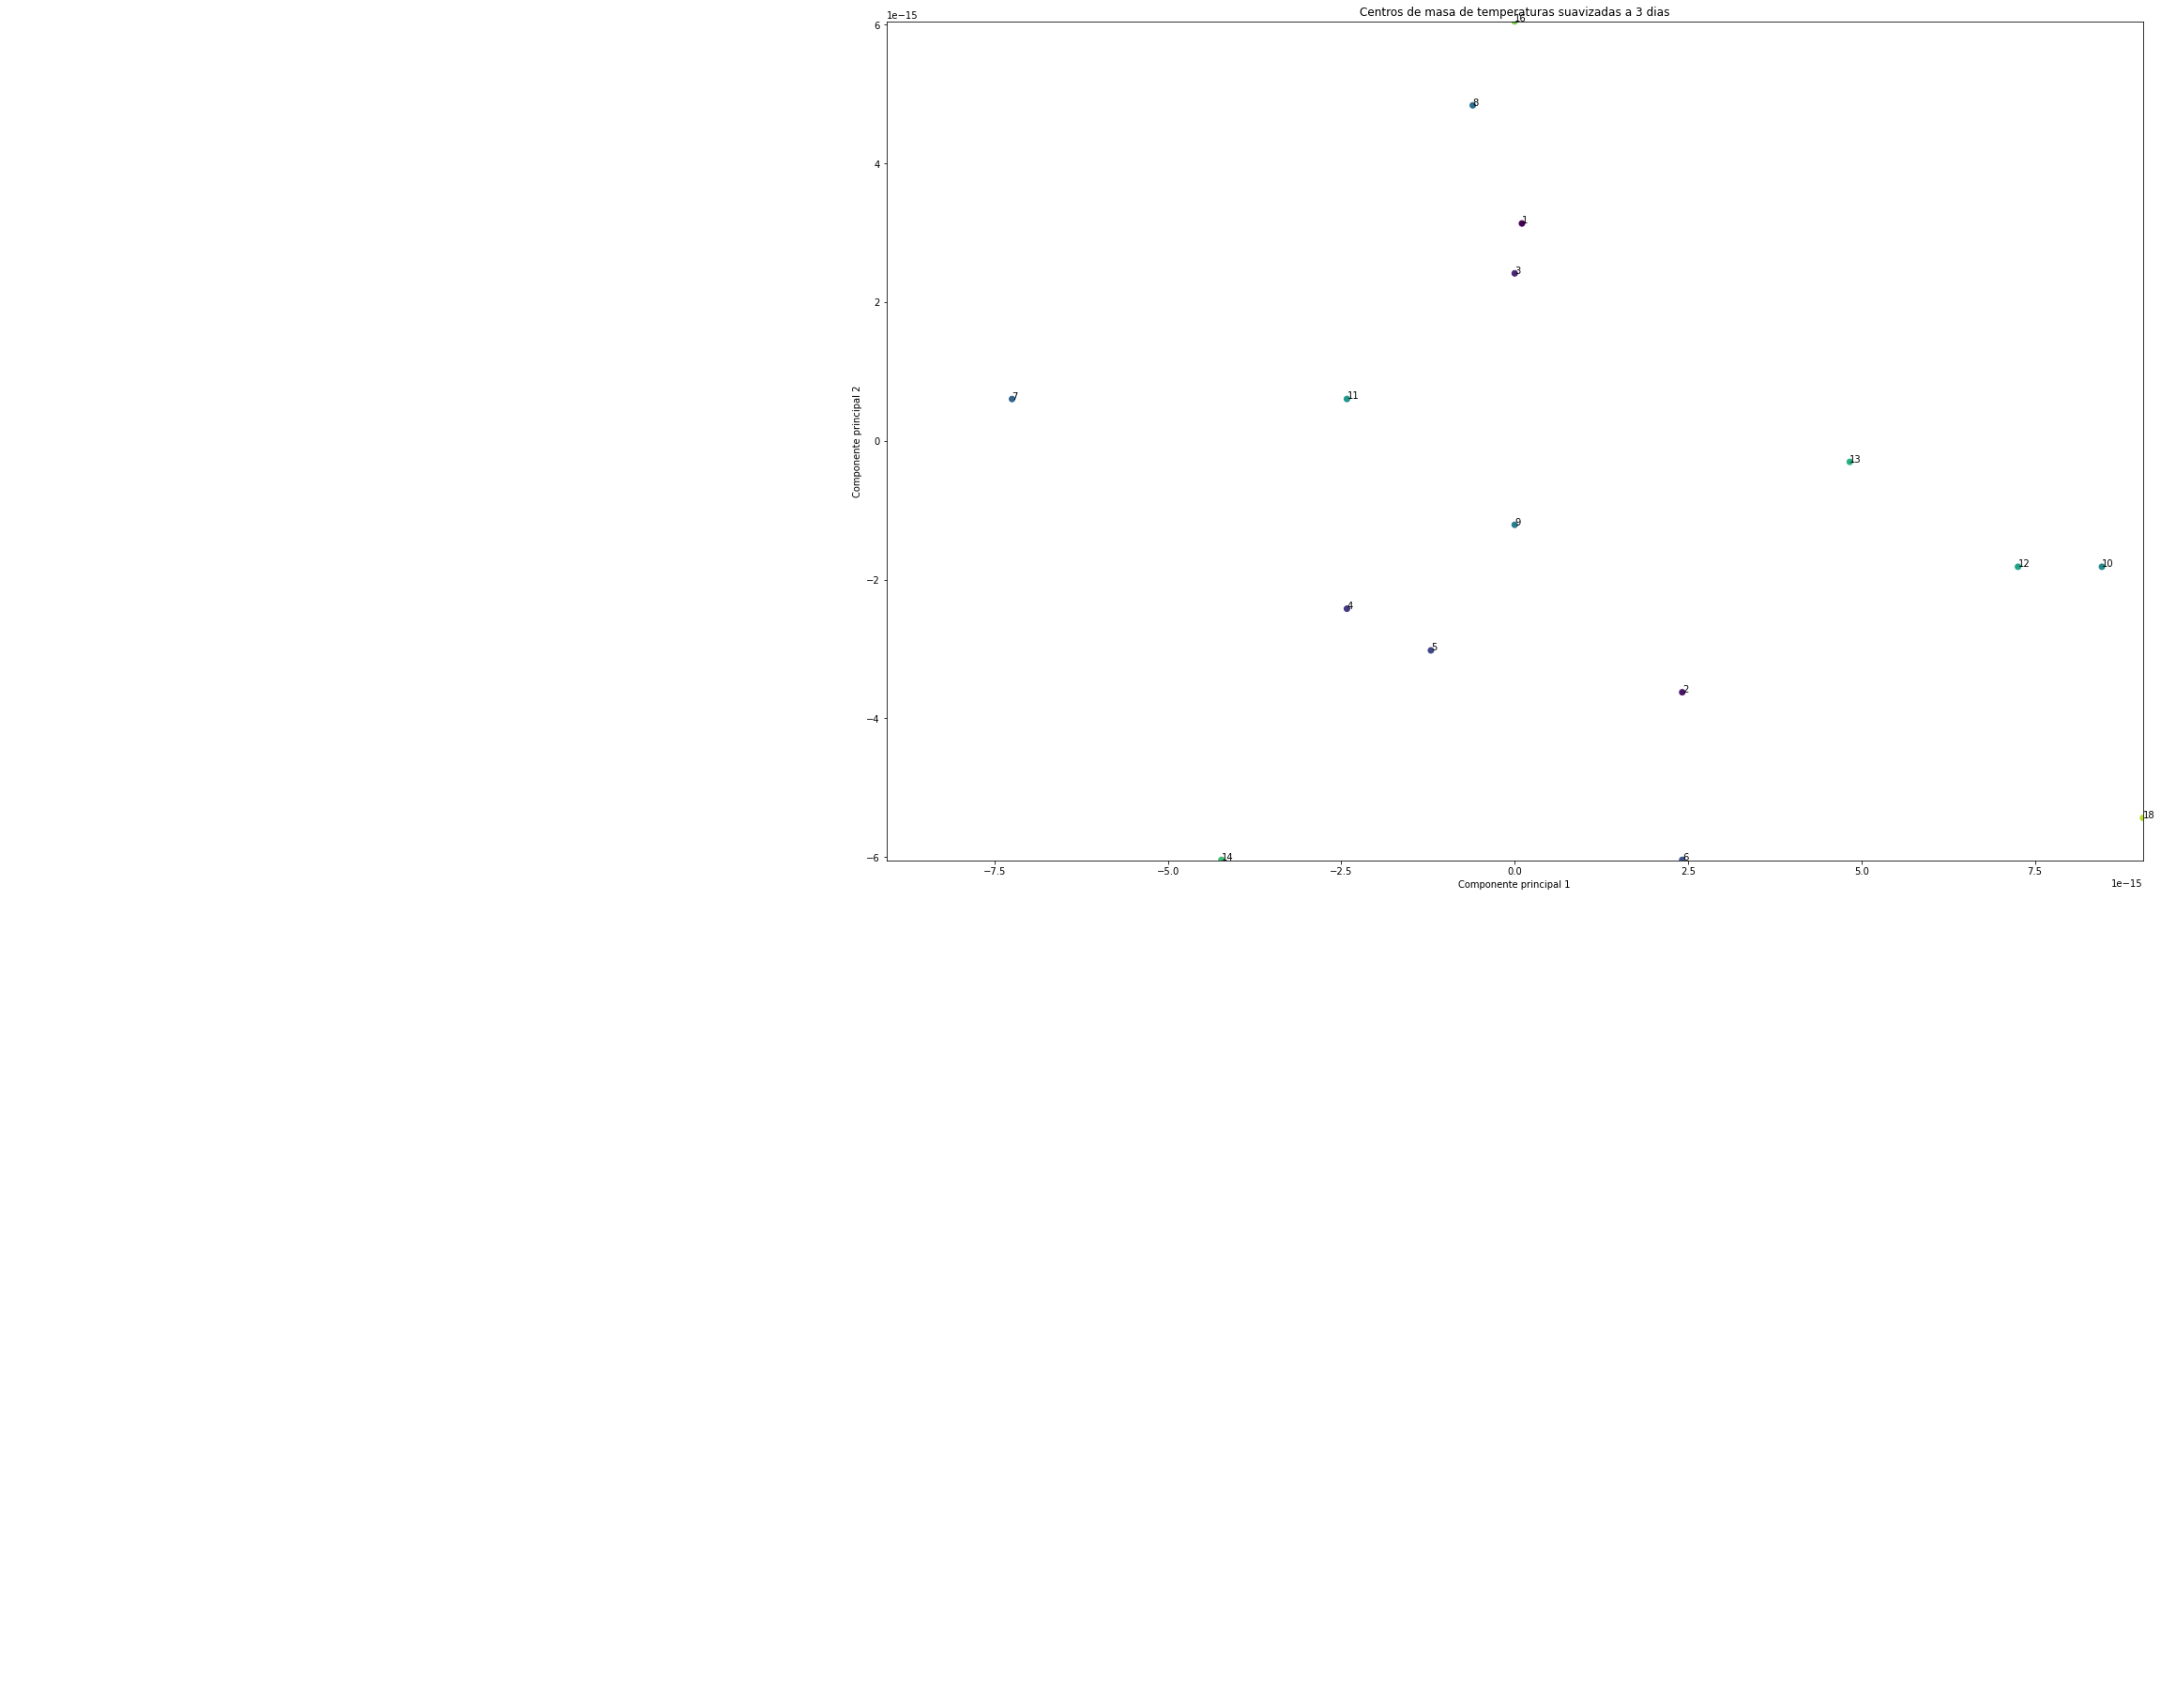

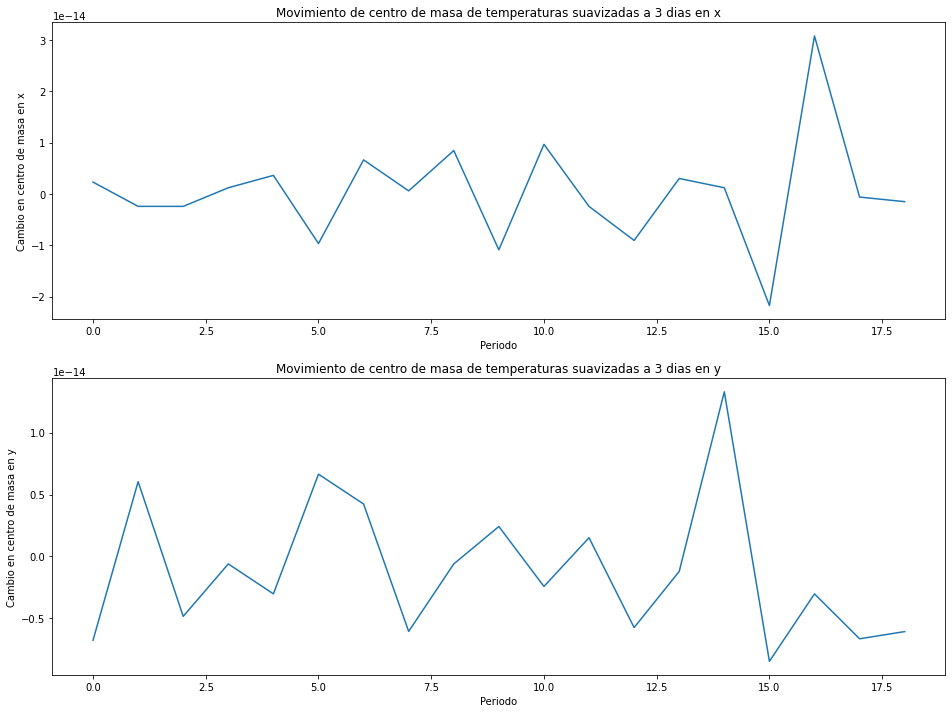

In [53]:
cmTx,cmTy=centrosDeMasa2d(temps2d,'temperaturas suavizadas a '+str(n)+' dias')
cambiosCentrosDeMasa2d(cmTx,cmTy,'temperaturas suavizadas a '+str(n)+' dias')

#### Flujos

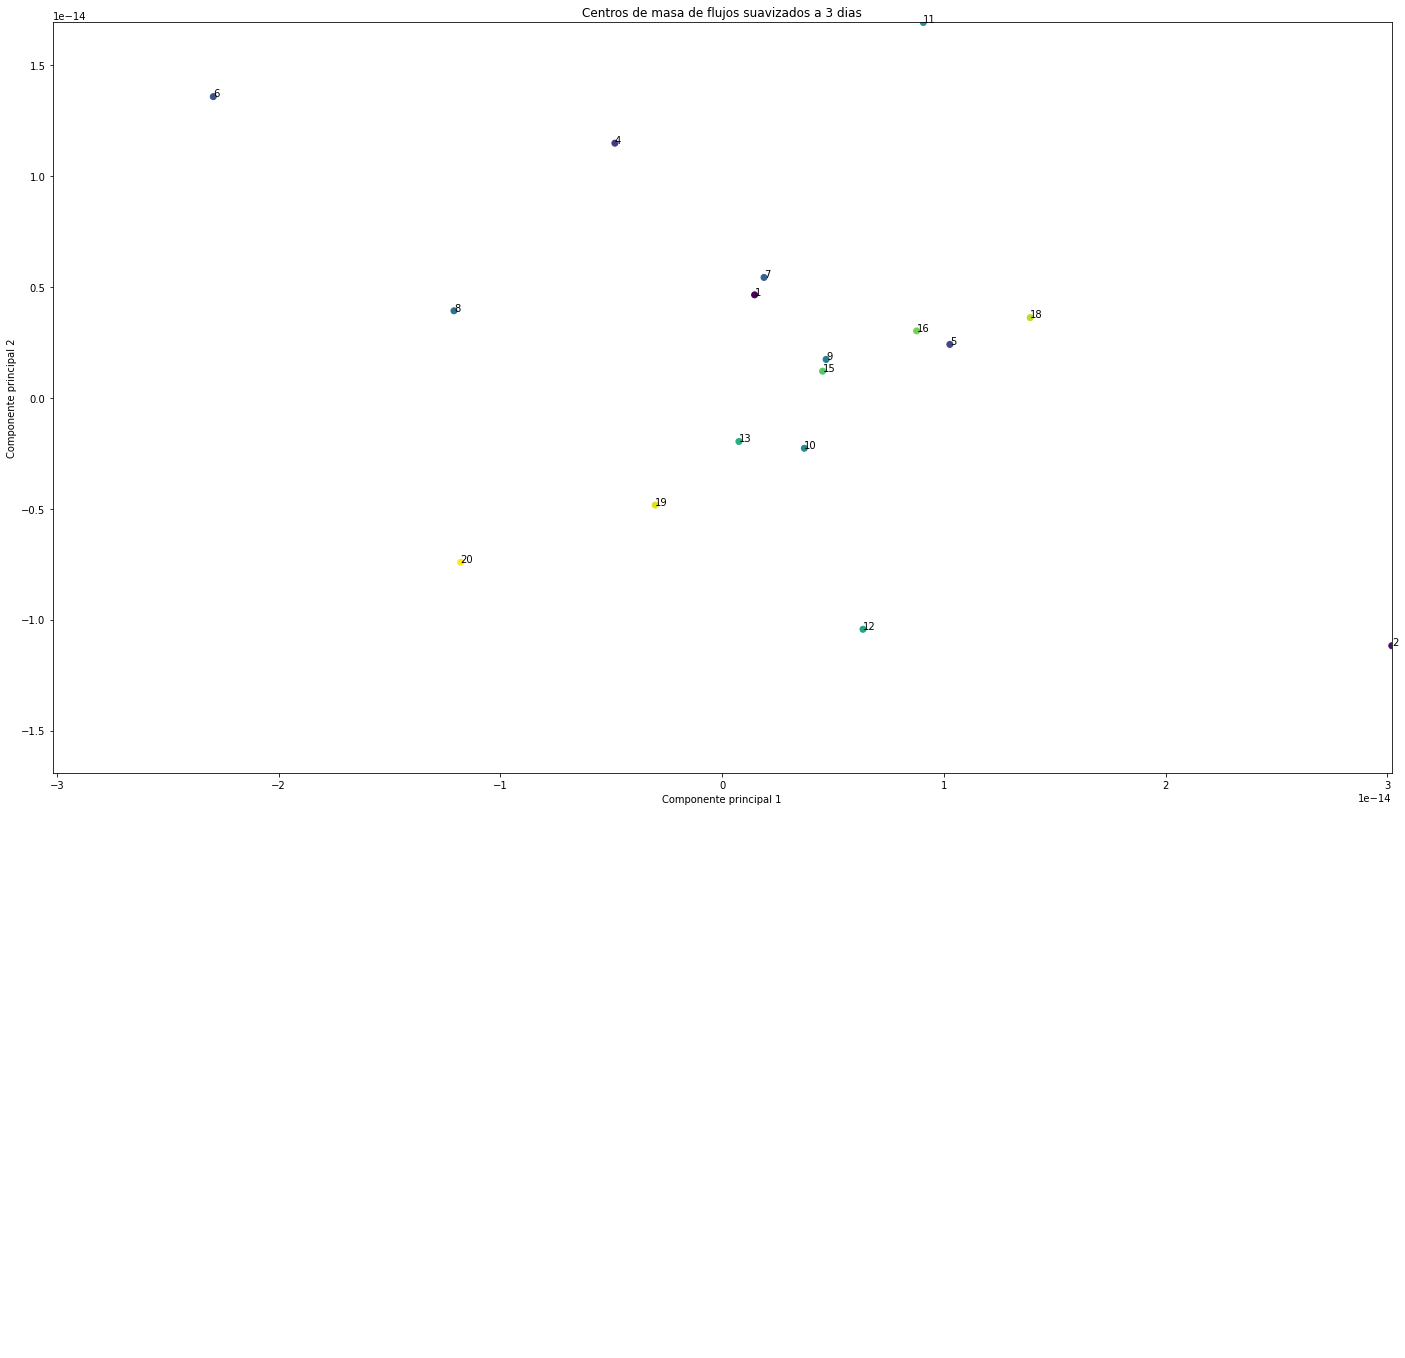

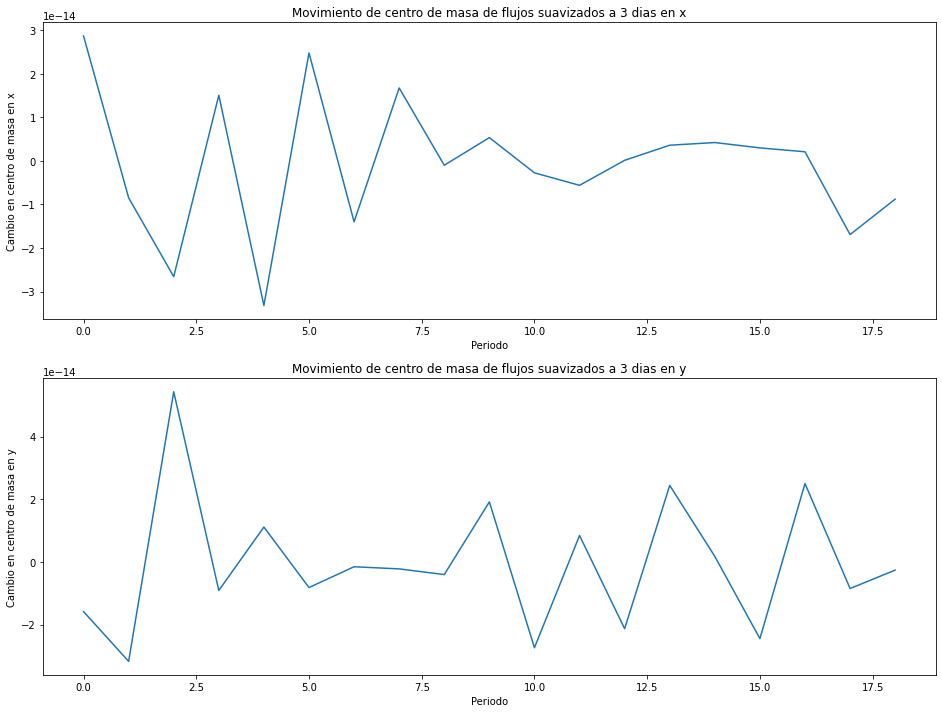

In [54]:
cmFx,cmFy=centrosDeMasa2d(flows2d,'flujos suavizados a '+str(n)+' dias')
cambiosCentrosDeMasa2d(cmFx,cmFy,'flujos suavizados a '+str(n)+' dias')

In [55]:
def die2dLinePlotterZeug(x:list,var:str,title:str)-> None:
  '''Devuelve un plot por año de la variable especificada a lo largo de 
  la fecha'''
  yl=0
  # Busca los valores maximos para usarlos como limites en las graficas
  for i in range(len(x)):
    if max(x[i][var])>yl:
      yl=max(x[i][var])
  # Genera las graficas iterativamente
  fig, axs = plt.subplots(ceil(len(x)/4), 4,figsize=(25, 75))
  for i in range(len(x)):
    axs[floor(i/4), i%4].plot(x[i]['obs_dates'],x[i][var])
    axs[floor(i/4), i%4].set_title('Periodo '+str(i+1)+' de '+title)
    axs[floor(i/4), i%4].set_xlabel('Fecha')
    axs[floor(i/4), i%4].set_ylabel('Flujo')
    axs[floor(i/4), i%4].set_ylim((-yl,yl))
    axs[floor(i/4), i%4].set_aspect('equal','box')
  # Elimina subplots vacios si es que existen
  if len(x)<ceil(len(x)/4)*4:
    for j in range(i+1,ceil(len(x)/4)*4):
      fig.delaxes(axs[floor(j/4)][j%4])
  return fig


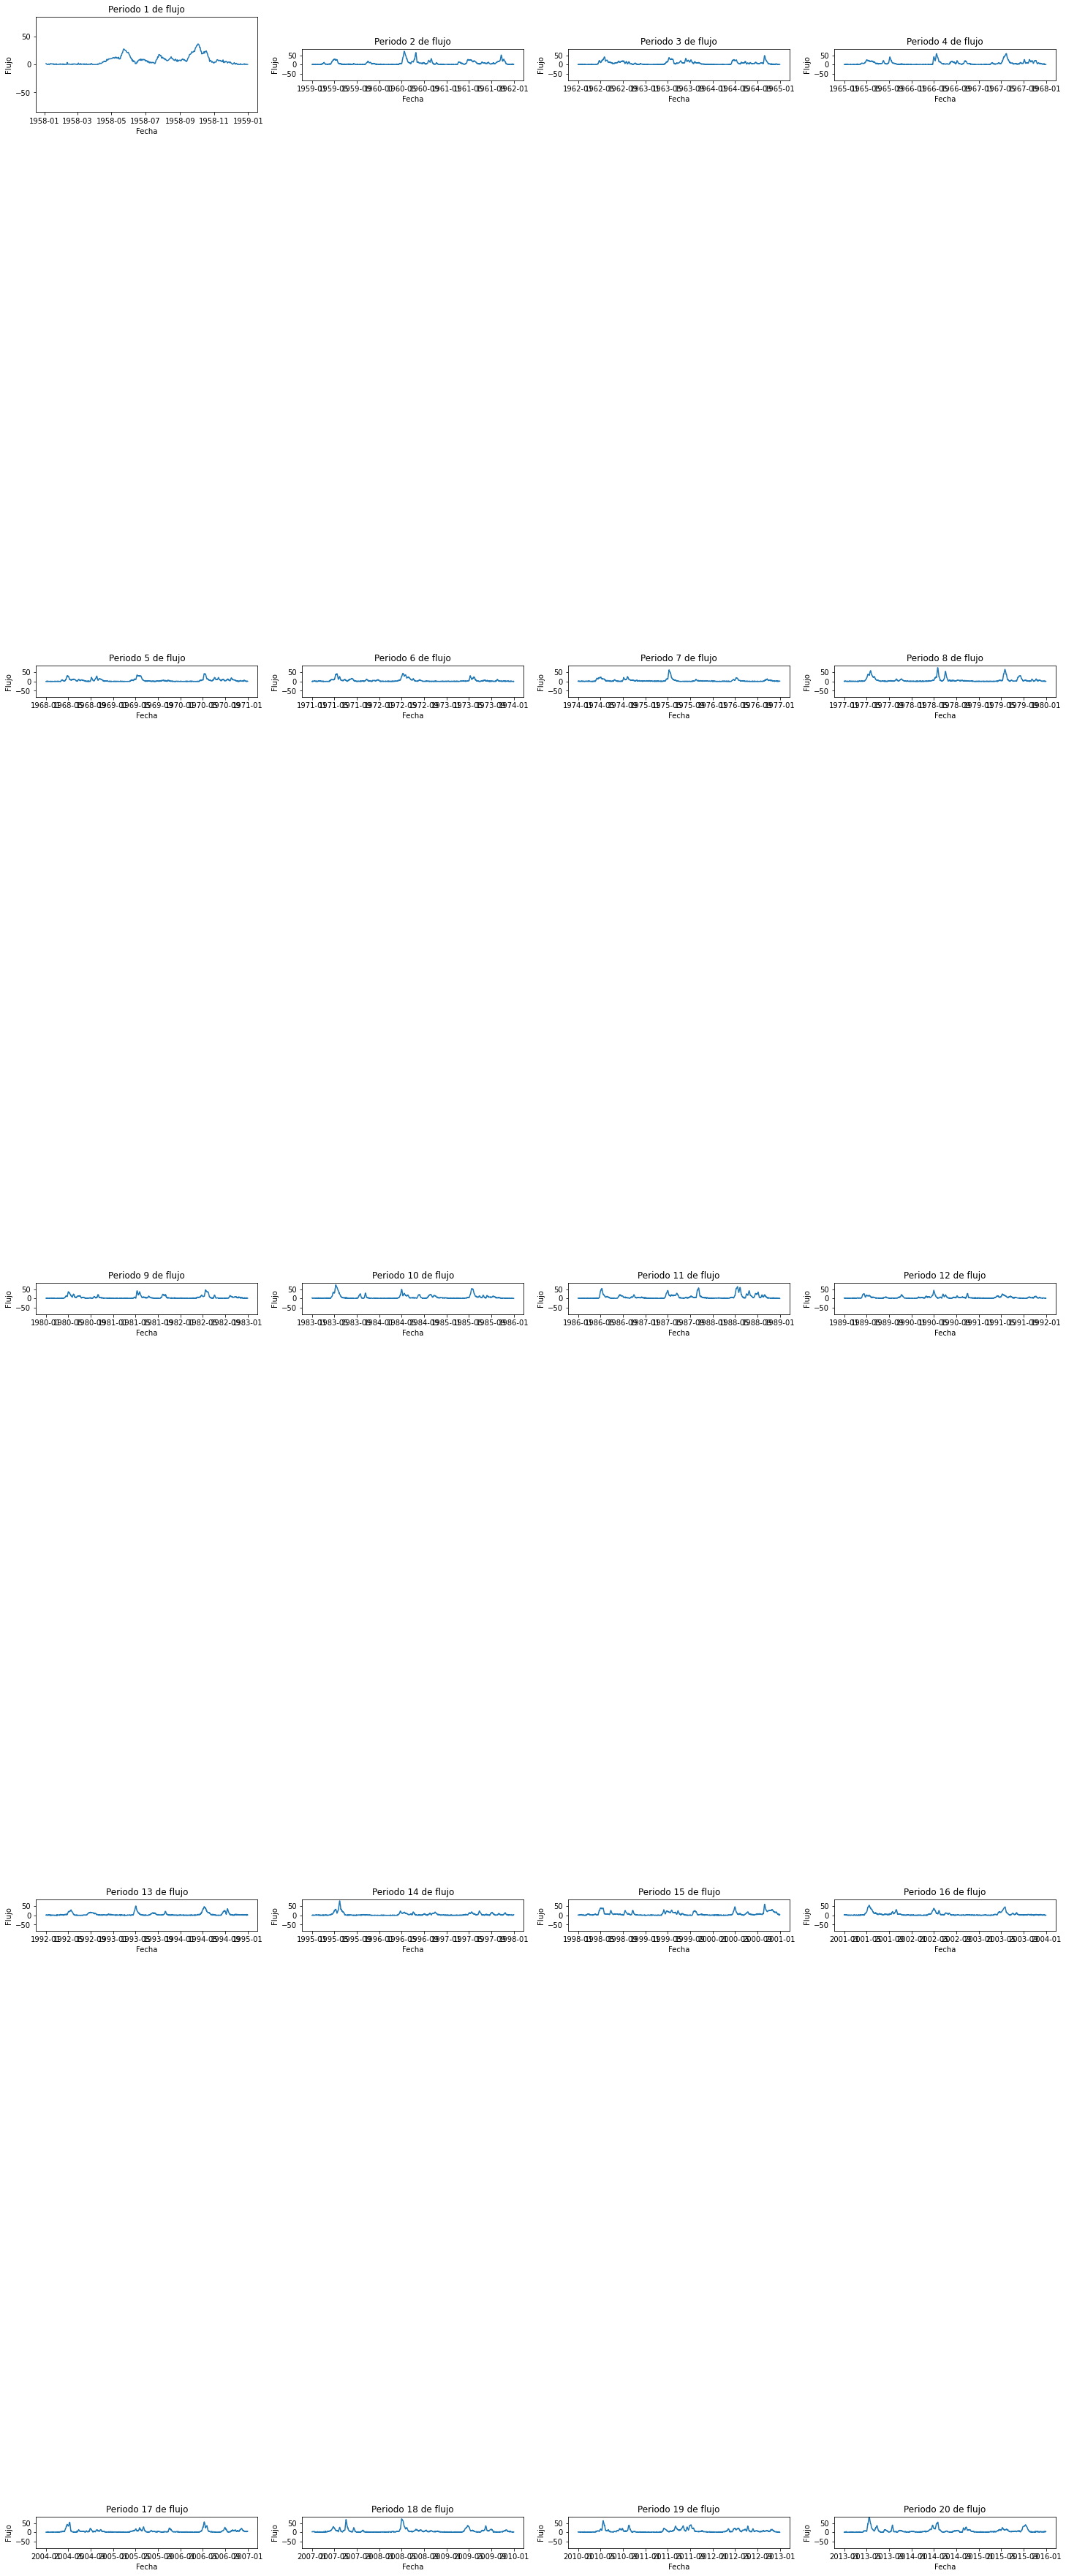

In [56]:
x=die2dLinePlotterZeug(years,'flow','flujo')

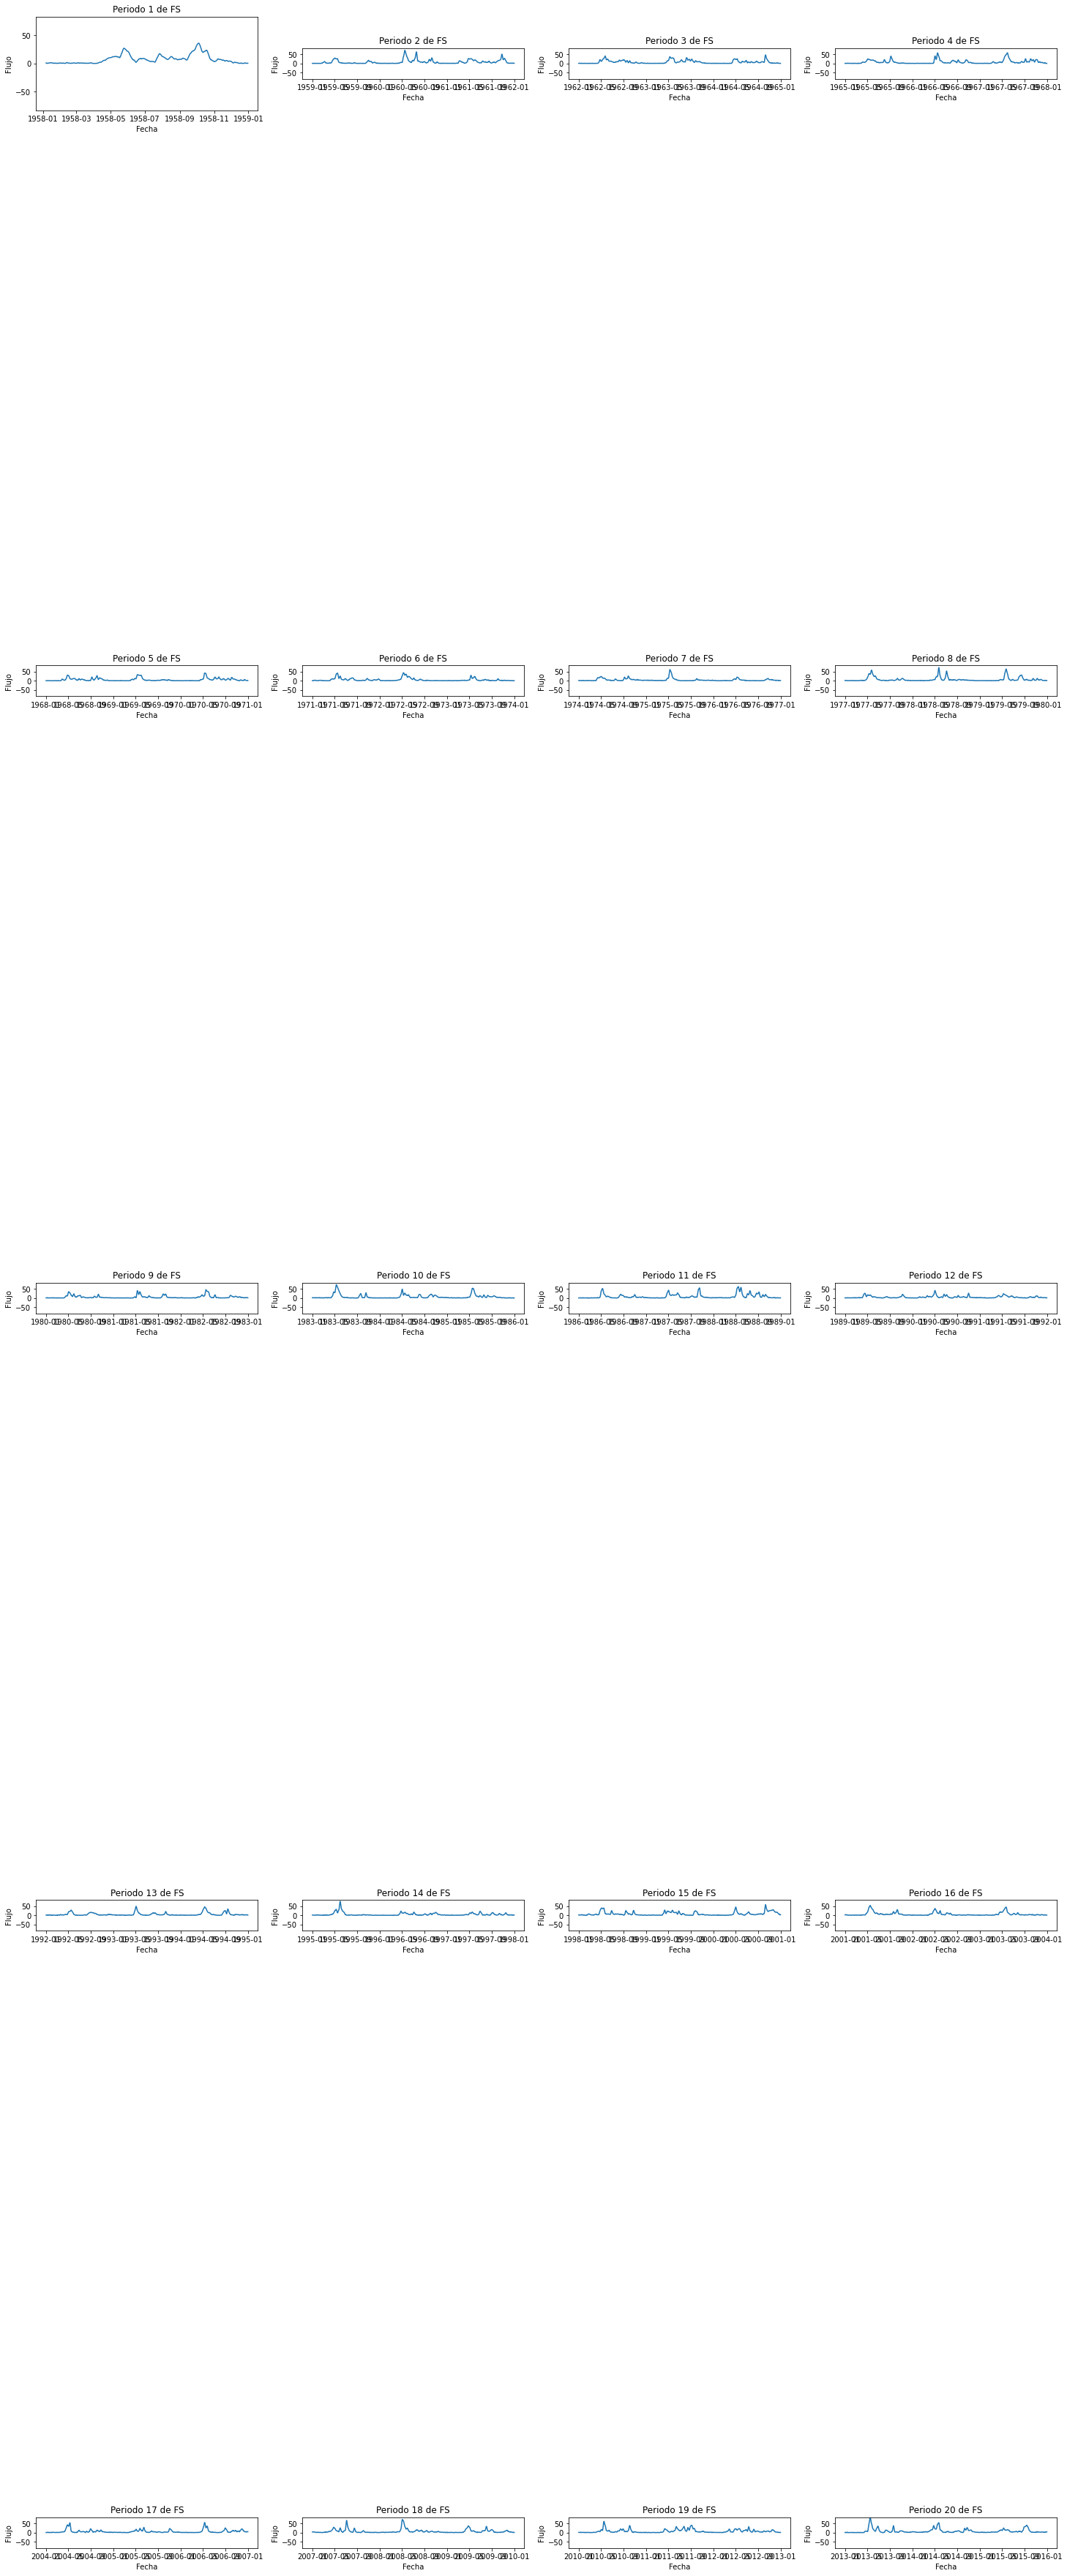

In [57]:
x=die2dLinePlotterZeug(yearsSoft,'rolling_flow_3','FS')